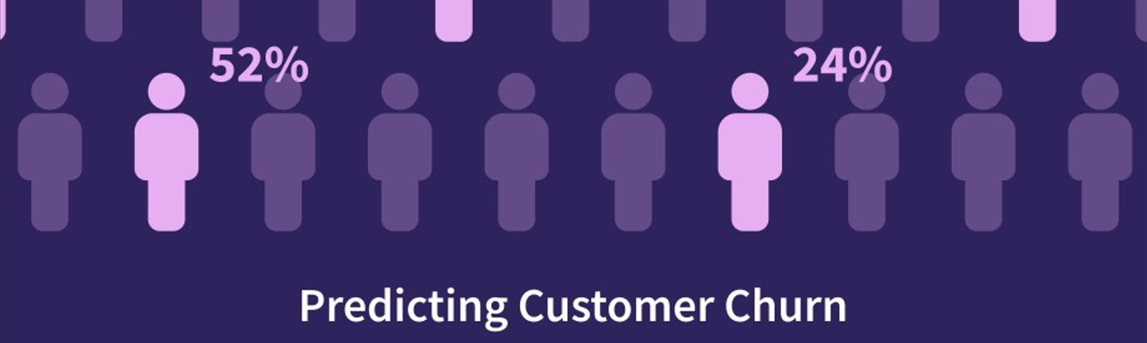

# <div style="color:white;display:fill;border-radius:5px;background-color:#645f89;font-family:Arial;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;letter-spacing:0.5px;margin:0"><b>1 |</b> Introduction</p></div>

## Goals:
Retaining customers is key to a company's success, especially in an industry as competitive as wireless services. Acquiring new customers is not only more difficult, but also much more costly to companies than maintaining existing customer relationships. In this notebook, I will predict behavior to retain customers at a home phone and internet service provider called Telco.

## Steps:
**Perform an Exploratory Data Analysis (EDA) to visualize and understand:**
* The distribution of values of the target and features;
* The relationship between each feature and the likelihood of customer churn.

**Predict churn using 20% of data as test set using the following models:**
* Logistic Regression;
* Random Forest;
* XGBoost;
* Catboost.

**Model Evaluation Metrics:**

Since the cost of maintaining a customer is less than the loss of revenue of lossing an existing customer, we want to avoid false negatives (Churn customers who are not recognized) as much as possible. False positive (a not-churn customer identified as churn) are not as important as preventing a churning. Therefore, the most suitable metric are:

* Recall: the ability of a model to find all the relevant cases within a dataset.
* ROC-AUC: ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

**Understand how each feature impacts the predicted value using:**
* Feature Importance;
* SHAP.

# <div style="color:white;display:fill;border-radius:5px;background-color:#645f89;font-family:Arial;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;letter-spacing:0.5px;margin:0"><b>2 |</b> Data Overview</p></div>

The dataset from Telco consists of 7,043 records with twenty attributes divided into two categories: customer demographic data and  information related to their wireless accounts. 

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

There were 11 customers with missing `TotalCharges`. Since it is a fairly small amount, these observations will be removed prior to beginning the analysis, leaving 7,032 customers in the data set. 

# <div style="color:white;display:fill;border-radius:5px;background-color:#645f89;font-family:Arial;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;letter-spacing:0.5px;margin:0"><b>3 |</b> Exploratory Data Analysis</p></div>
## <b><span style='color:#645f89'>3.1</span> | Data Imbalance Check</b>

In [1]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from catboost import Pool

import shap

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/kaggle/input/telco-customer-churn/Telco_customer_churn_All_revised.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 56 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Count                              7043 non-null   int64  
 2   Gender                             7043 non-null   object 
 3   Age                                7043 non-null   int64  
 4   Under 30                           7043 non-null   object 
 5   Senior Citizen                     7043 non-null   object 
 6   Married                            7043 non-null   object 
 7   Dependents                         7043 non-null   object 
 8   Number of Dependents               7043 non-null   int64  
 9   Location ID                        7043 non-null   object 
 10  Country                            7043 non-null   object 
 11  State                              7043 non-null   objec

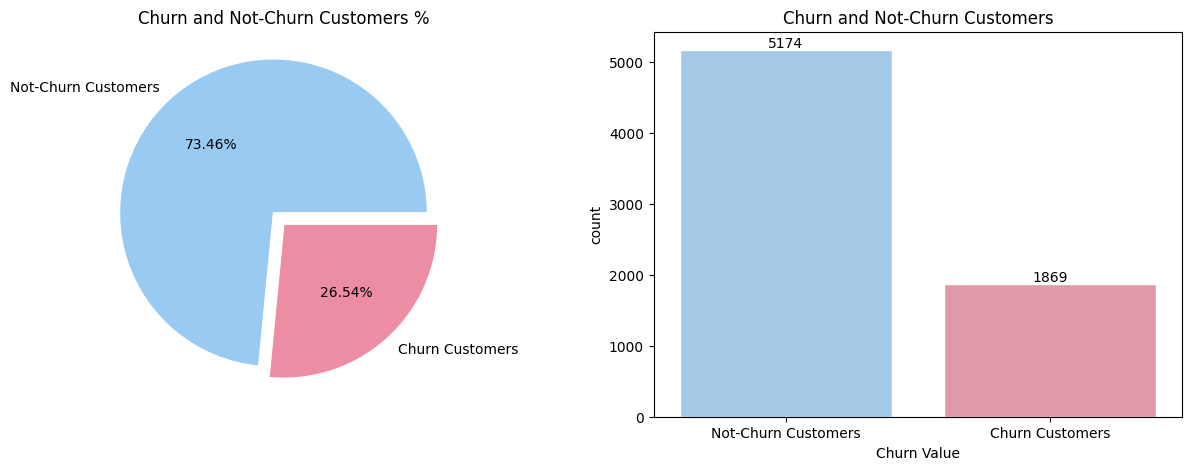

In [2]:
l1 = list(df['Churn Value'].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1, ncols= 2, figsize = (15,5))

# Defining the colors for the plots
palette = ['#98CAF2', '#EC8DA3','#3A4EA7', '#BB5B6A']

plt.subplot(1,2,1) # Select the first subplot
plt.pie(pie_values, labels = ['Not-Churn Customers', 'Churn Customers'],
       autopct = '%1.2f%%', # the value should be displayed as a floating point number with 2 digits after the decimal point.
       explode = (0.1,0),  #  specify the fraction of the radius with which to offset each wedge of a pie chart.
       colors = palette,
       wedgeprops= {'edgecolor': 'white', 'linewidth': 1, 'antialiased' : True})   # 'antialiased': True is enabling antialiasing
plt.title('Churn and Not-Churn Customers %')

plt.subplot(1,2,2) # Select the second subplot
ax = sns.countplot(data = df,
                  x='Churn Value',
                  palette = palette,
                  edgecolor = 'white')
for i in ax.containers:
    ax.bar_label(i)
ax.set_xticklabels(['Not-Churn Customers', 'Churn Customers'])

plt.title('Churn and Not-Churn Customers')
plt.show()

### Key Findings
Dataset is imbalanced almost 1:4 ratio. It's not an extreme value, but it's still significant.

This means that a blind guess (bet on "Not-Churn") would give us accuracy of 73.46%.

* We should use stratified splitting during train-test split.
* We should be extra careful when dealing with outliers (because we may delete meaningful information).
* We should consider undersampling or oversampling techniques.

## <b><span style='color:#645f89'>3.2</span> | Distribution and Skewness</b>

When working with numerical features, one of the most informative statistics we can look at is the distribution of the data. We used a Kernel-Density-Estimation plot to visualize the probability distributions of the relative variables.

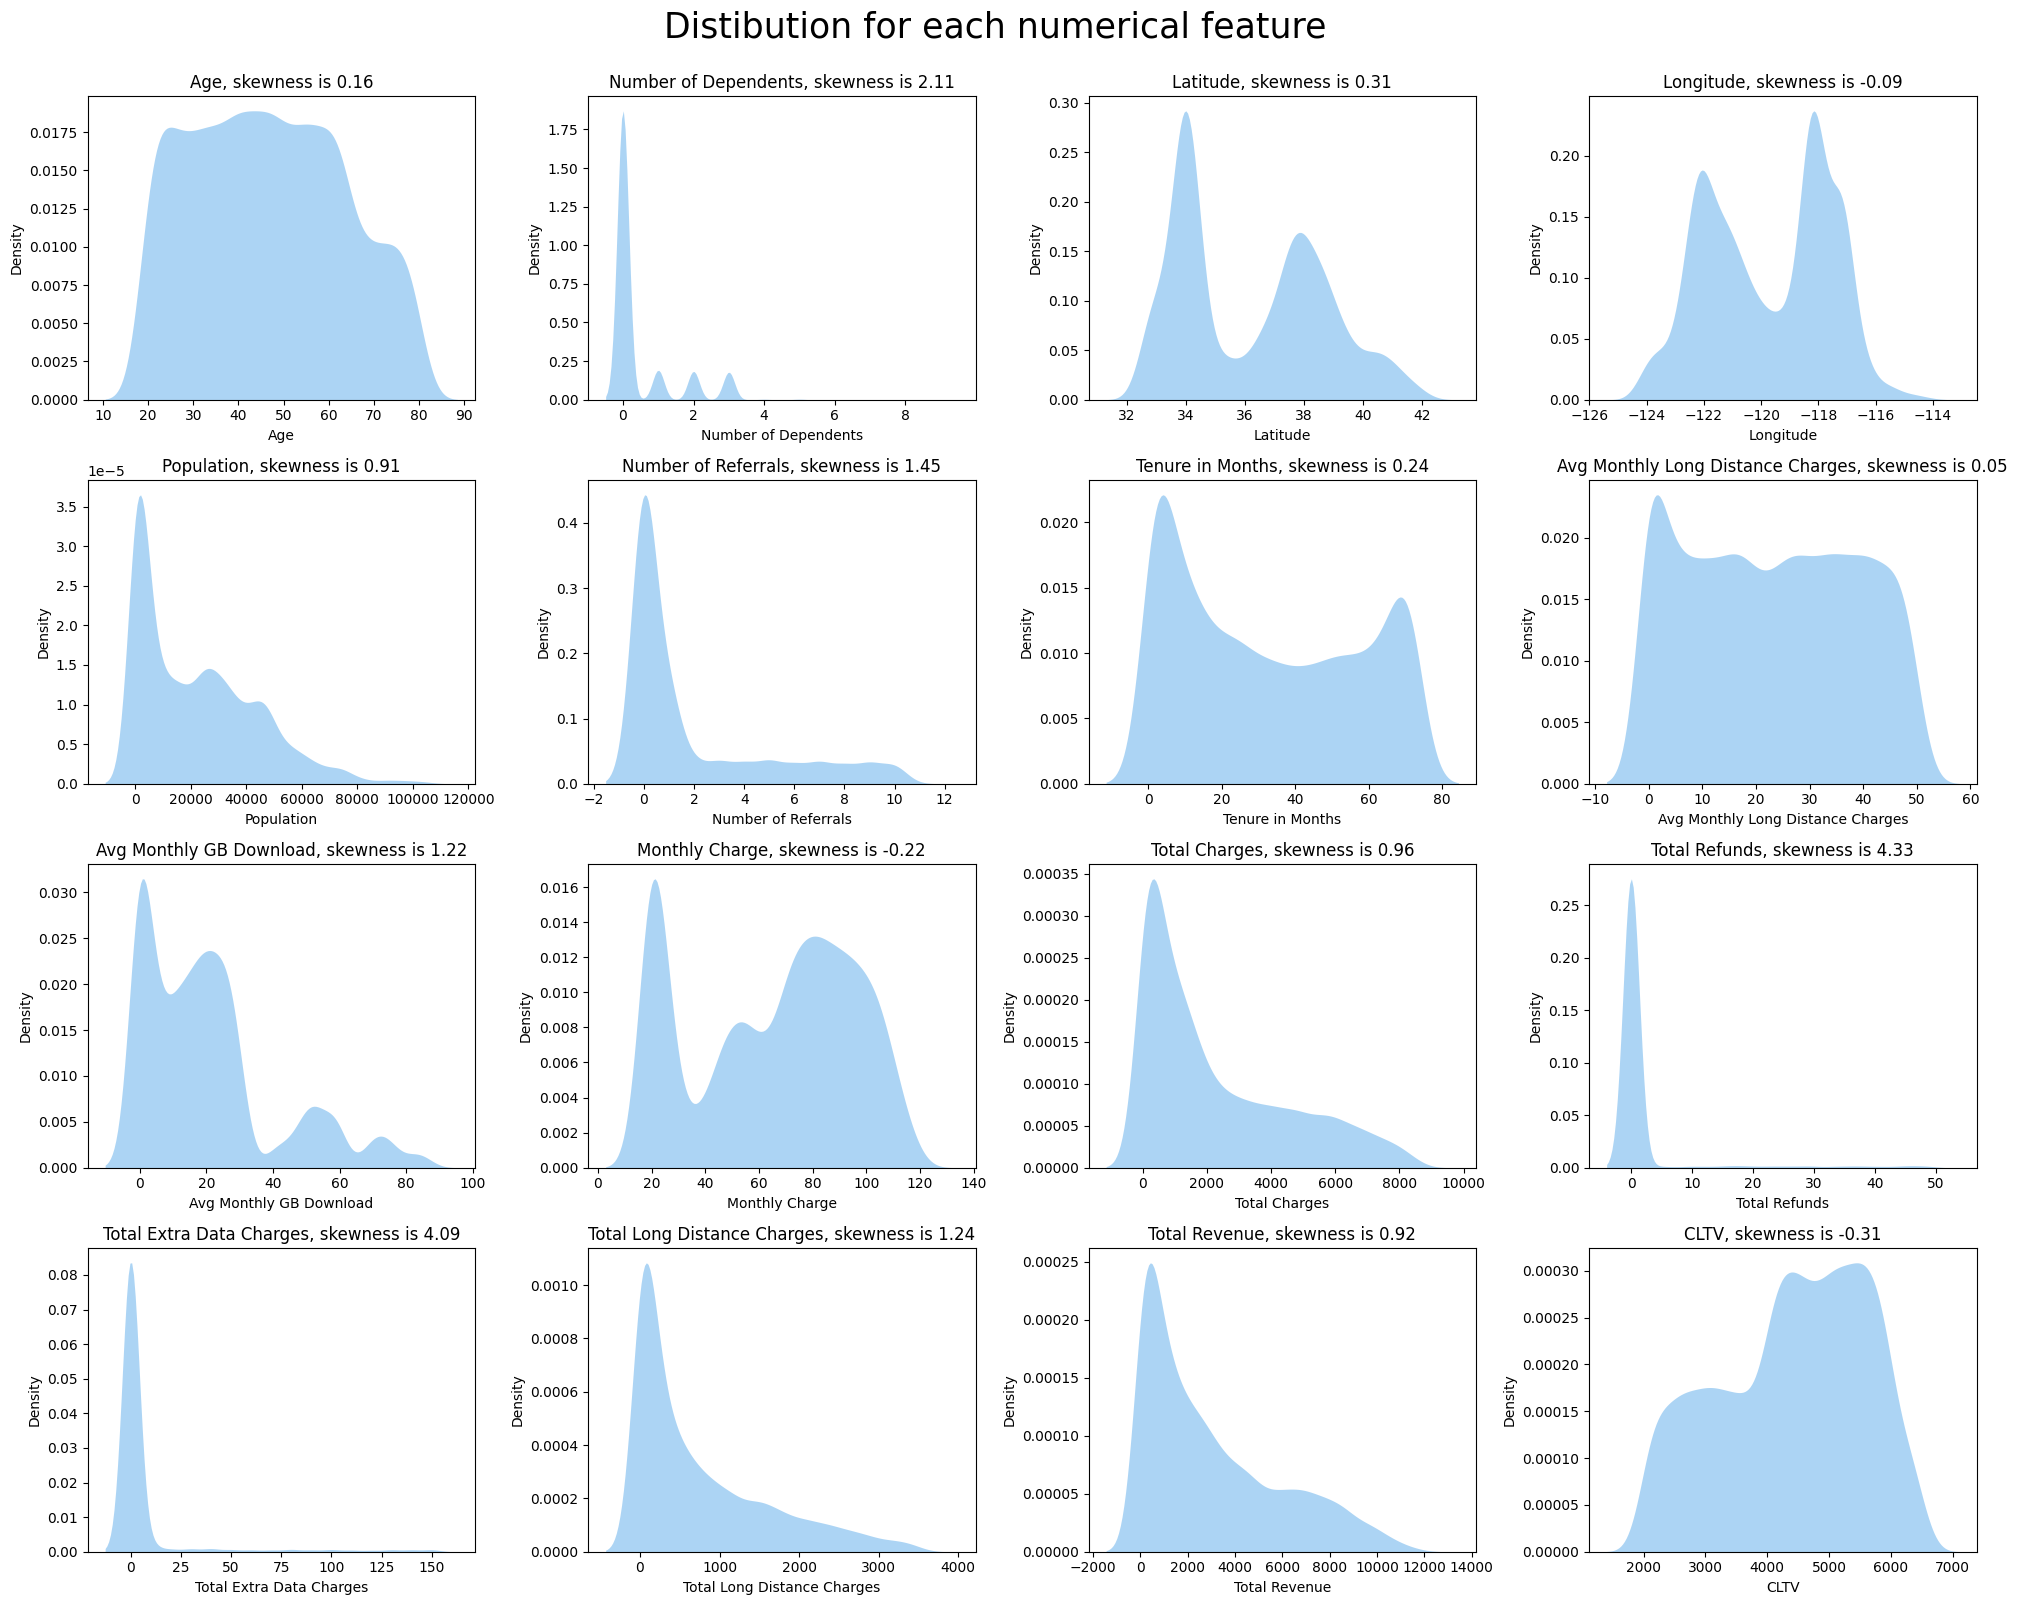

In [3]:
columns = list(df.columns)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
categoric_columns = [col for col in columns if col not in numeric_columns]

items_to_remove = ['Count', 'Zip Code', 'Satisfaction Score', 'Churn Value', 'Churn Score']
filtered_numeric_columns = [item for item in numeric_columns if item not in items_to_remove]


# Checking for distributions
def dist_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, figsize=(20,16))
    fig.suptitle(suptitle,y=1, size=25)  # add a centered title to the figure
    axs = axs.flatten() # convert the multi-dimensional array of Axes objects into a one-dimensional array
    for i, data in enumerate(columns_list):
        sns.kdeplot(dataset[data], ax=axs[i], fill=True, alpha=0.8, linewidth=0, color='#98CAF2')  # plot a kernel density estimate (KDE)
        axs[i].set_title(data + ', skewness is '+str(round(dataset[data].skew(axis = 0, skipna = True),2))) # skipna = True means that missing values are ignored in the calculation
        
dist_custom(dataset=df, columns_list=filtered_numeric_columns, rows=4, cols=4, suptitle='Distibution for each numerical feature')
plt.tight_layout() # automatically adjust subplot parameters so that the subplots fit into the figure area nicely.

### Key Findings

* Our dataset are mainly customers are  30-65 years old. 
* Variables are not normally distributed.
* Population, Number of referrals, TotalCharges, Total long distance charges, Total revenue are rightly skewed.

## <b><span style='color:#645f89'>3.3</span> | Checking for outliers - Inter Quartile Range (IQR)</b>

Inter Quartile Range (IQR) is one of the most extensively used procedure for outlier detection and removal.

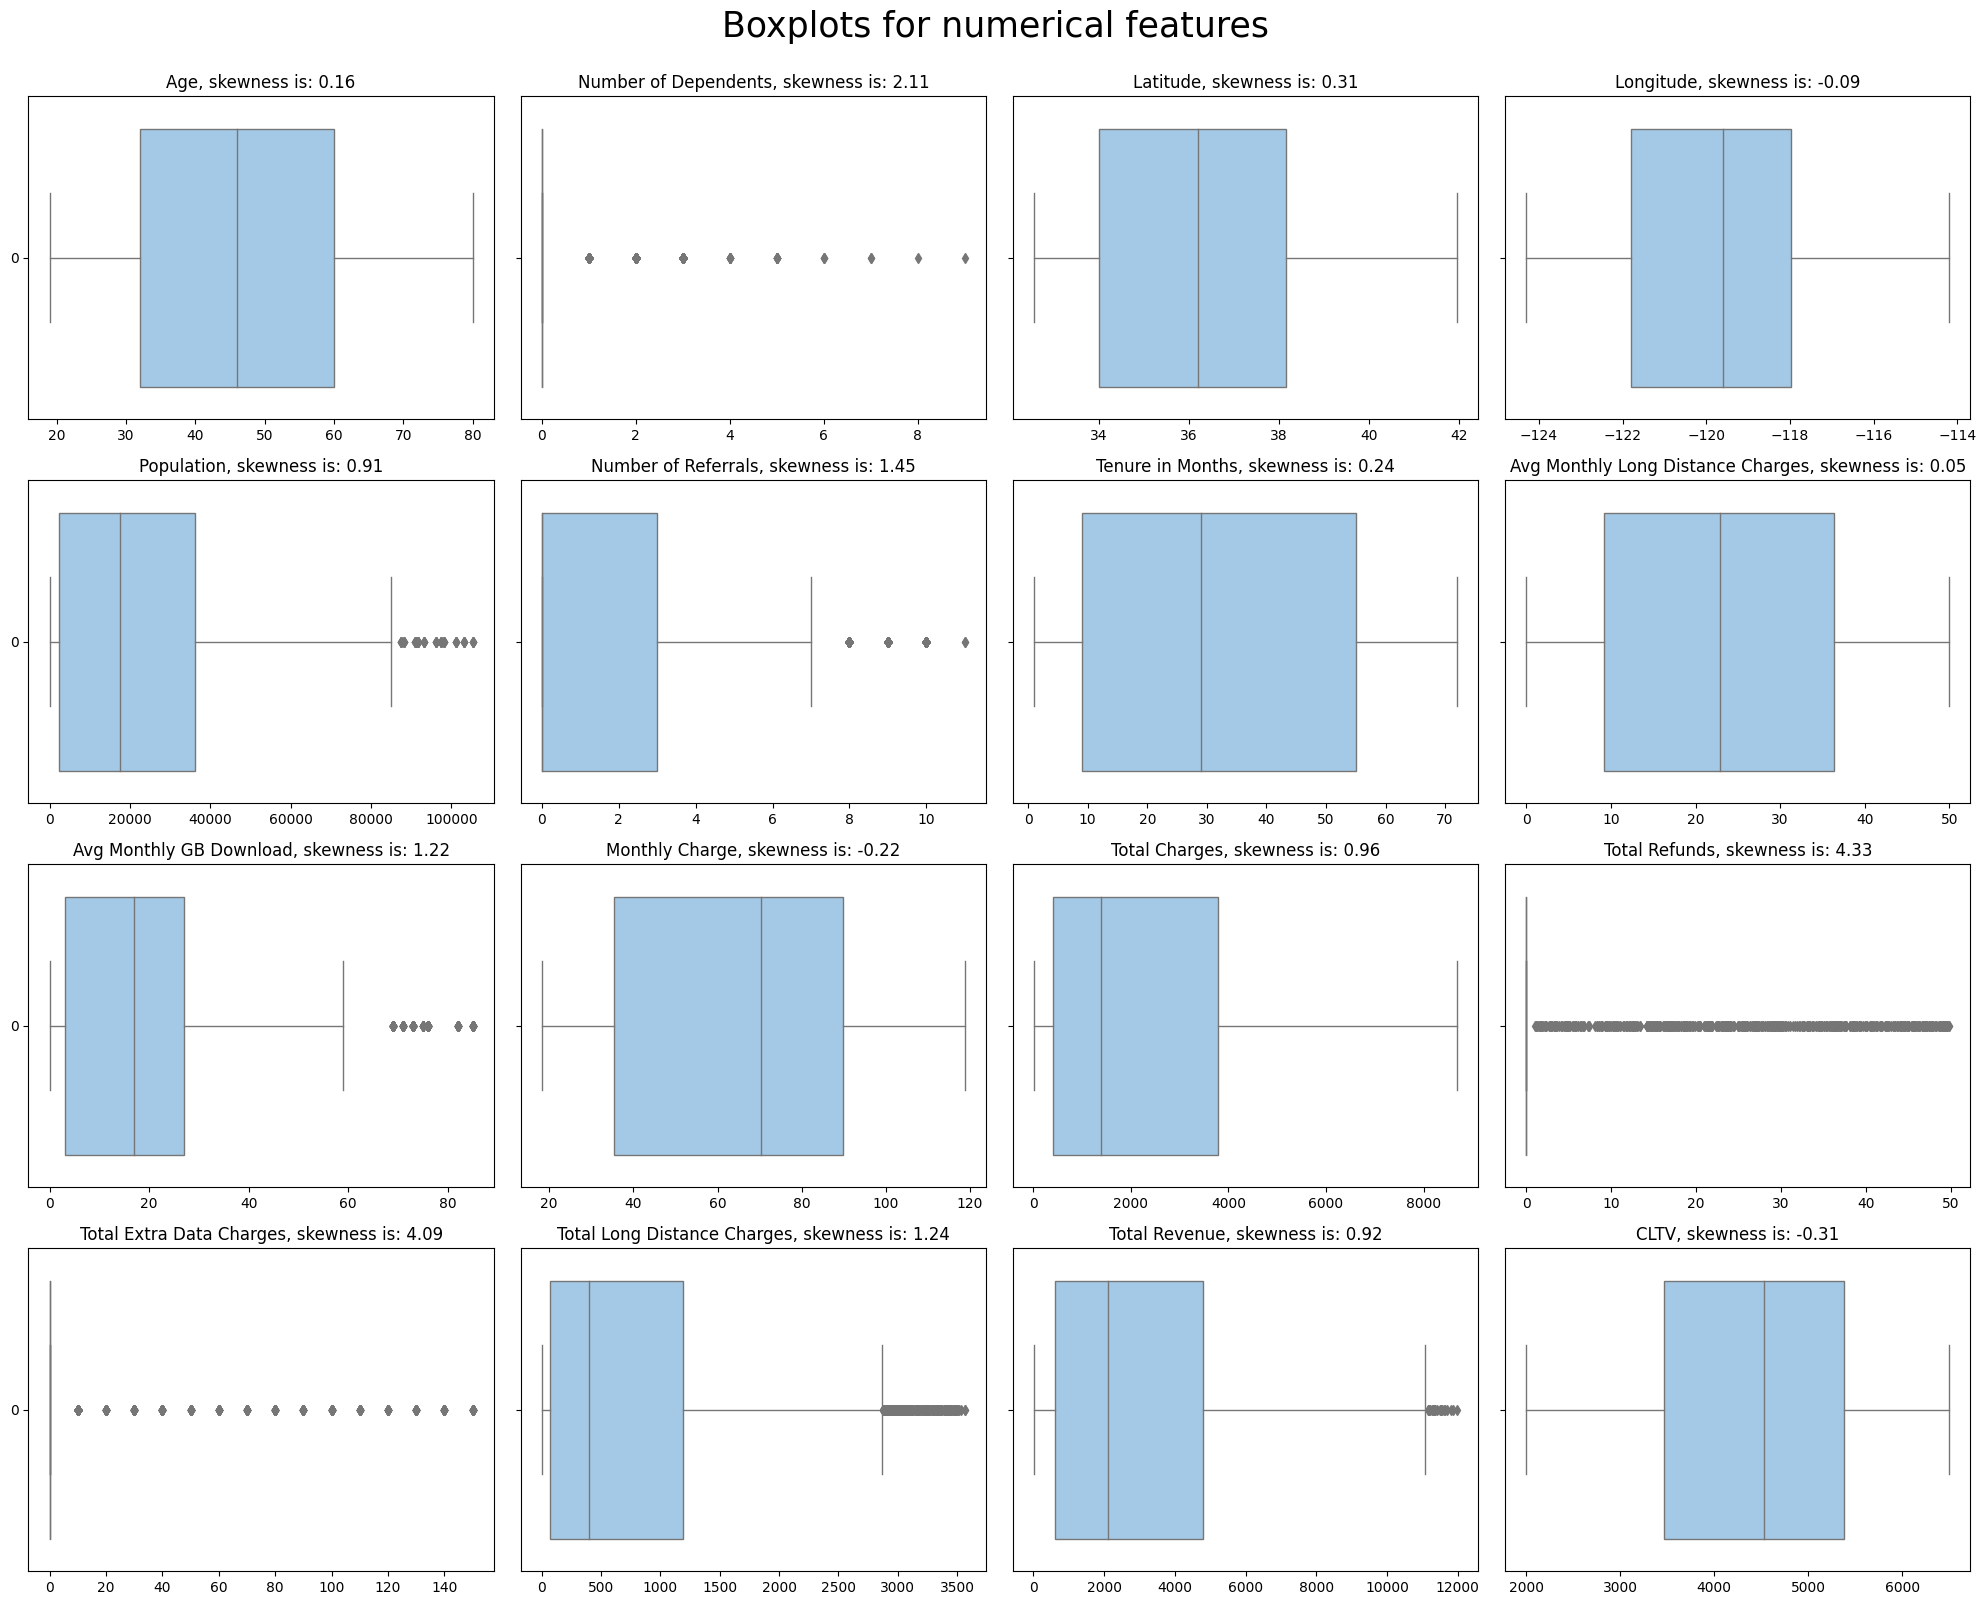

In [4]:
# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(20,16))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i], palette = palette, linewidth=1)
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=filtered_numeric_columns, rows=4, cols=4, suptitle='Boxplots for numerical features')
plt.tight_layout()

### Key Fidnings

* `Population` in each Zip Code area, `Number of Referrals`, `Avg Monthly GB Download`, `Total Long Distance Charges`, and `Total Revenue` has some outliers.
* To handle the outliers, we need to consider both analytics and context. Ultimately, the decision to keep or remove outliers would depend on their impact on the model's performance and the business outcome.
* I prefer to run models **with and without outliers** to compare the performance metrics. If the outliers help the model to generalize better and improve predictive accuracy on unseen data, they should be included. Otherwise, if they lead to overfitting or poor generalization, I might remove them or use robust methods that can handle outliers.

## <b><span style='color:#645f89'>3.4</span> | Numerical Features vs Target Variable (Churn)</b>

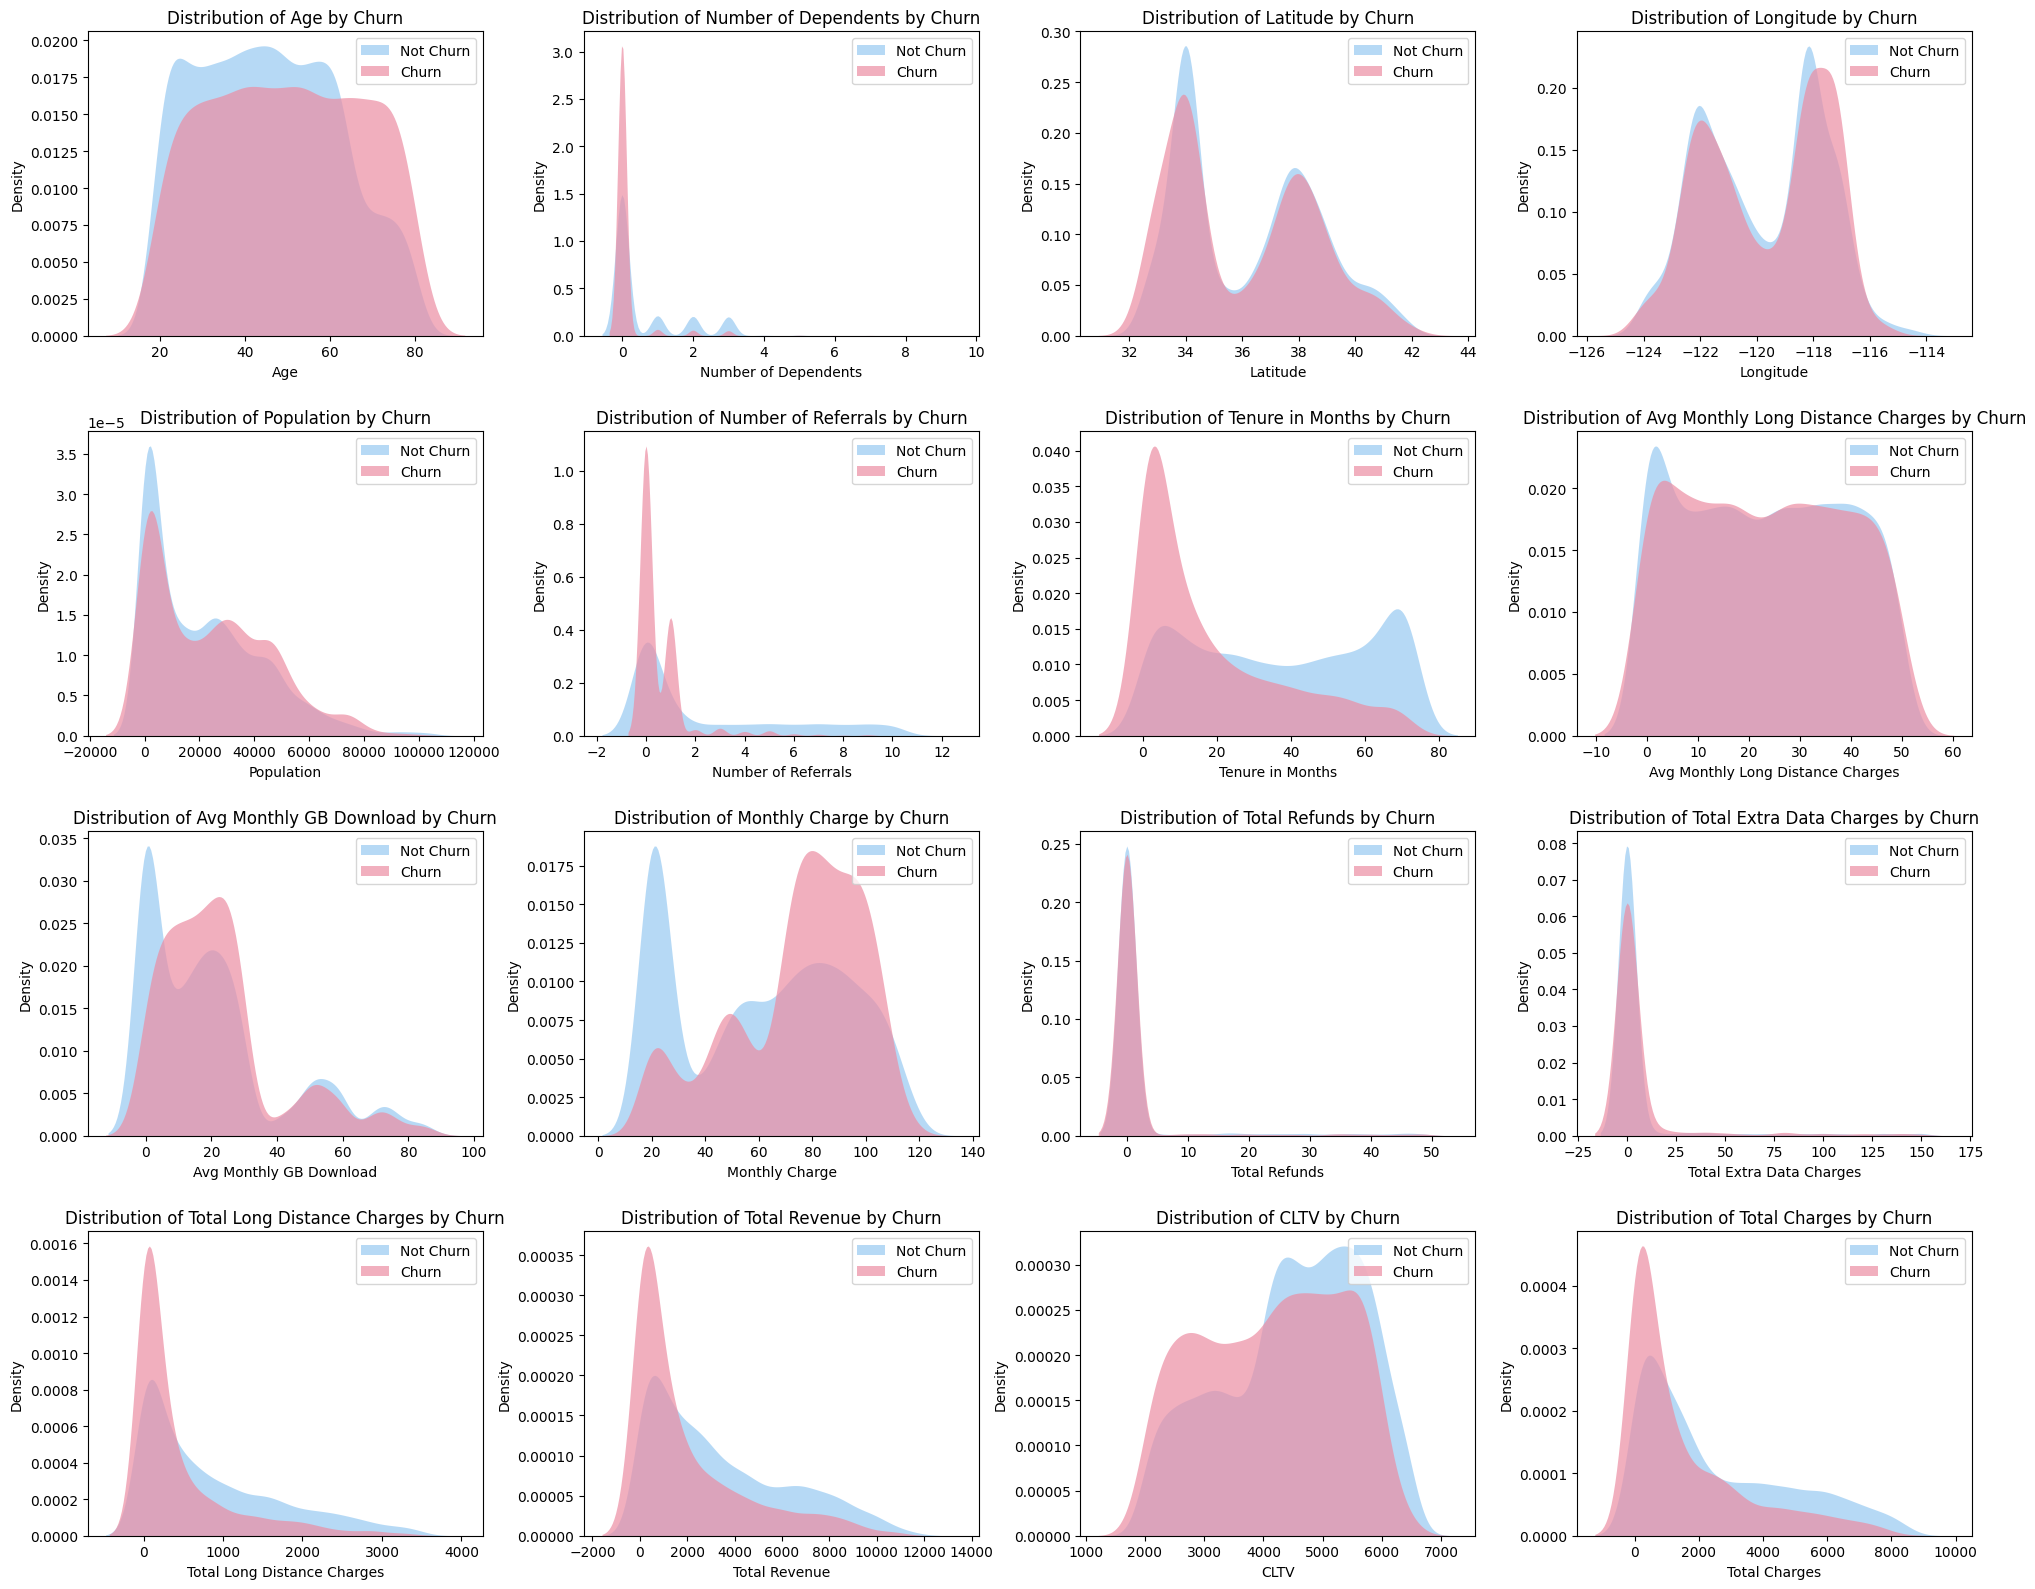

In [5]:
columns_to_plot = ["Age", "Number of Dependents", "Latitude", "Longitude", "Population", 
                   "Number of Referrals", "Tenure in Months", "Avg Monthly Long Distance Charges", 
                   "Avg Monthly GB Download", "Monthly Charge", "Total Refunds", 
                   "Total Extra Data Charges", "Total Long Distance Charges", 
                   "Total Revenue", "CLTV", "Total Charges"]

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))

for i, column in enumerate(columns_to_plot):
    ax = plt.subplot(4, 4, i+1)
    sns.kdeplot(df[column][(df['Churn Value'] == 0)], color='#98CAF2', fill=True, alpha=0.7, linewidth=0, ax=ax)
    sns.kdeplot(df[column][(df['Churn Value'] == 1)], color='#EC8DA3', fill=True, alpha=0.7, linewidth=0, ax=ax)
    ax.legend(["Not Churn", "Churn"], loc="upper right")
    ax.set_ylabel('Density')
    ax.set_xlabel(column)
    ax.set_title(f'Distribution of {column} by Churn')

# Hide any unused subplots
for i in range(len(columns_to_plot), 16):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

### Key Findings

* From the `Monthly Charge by Churn (line 3, 2nd Figure)`, The higher the monthly charge the more likely the customers will churn. Once the monthly fee exceeds **$60**, customers begin to churn in large numbers.

## <b><span style='color:#645f89'>3.5</span> | Time Analysis (Tenure in Months)</b>

* `Contract`: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.
* `Tenure in Months`: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.
* `CLTV`: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

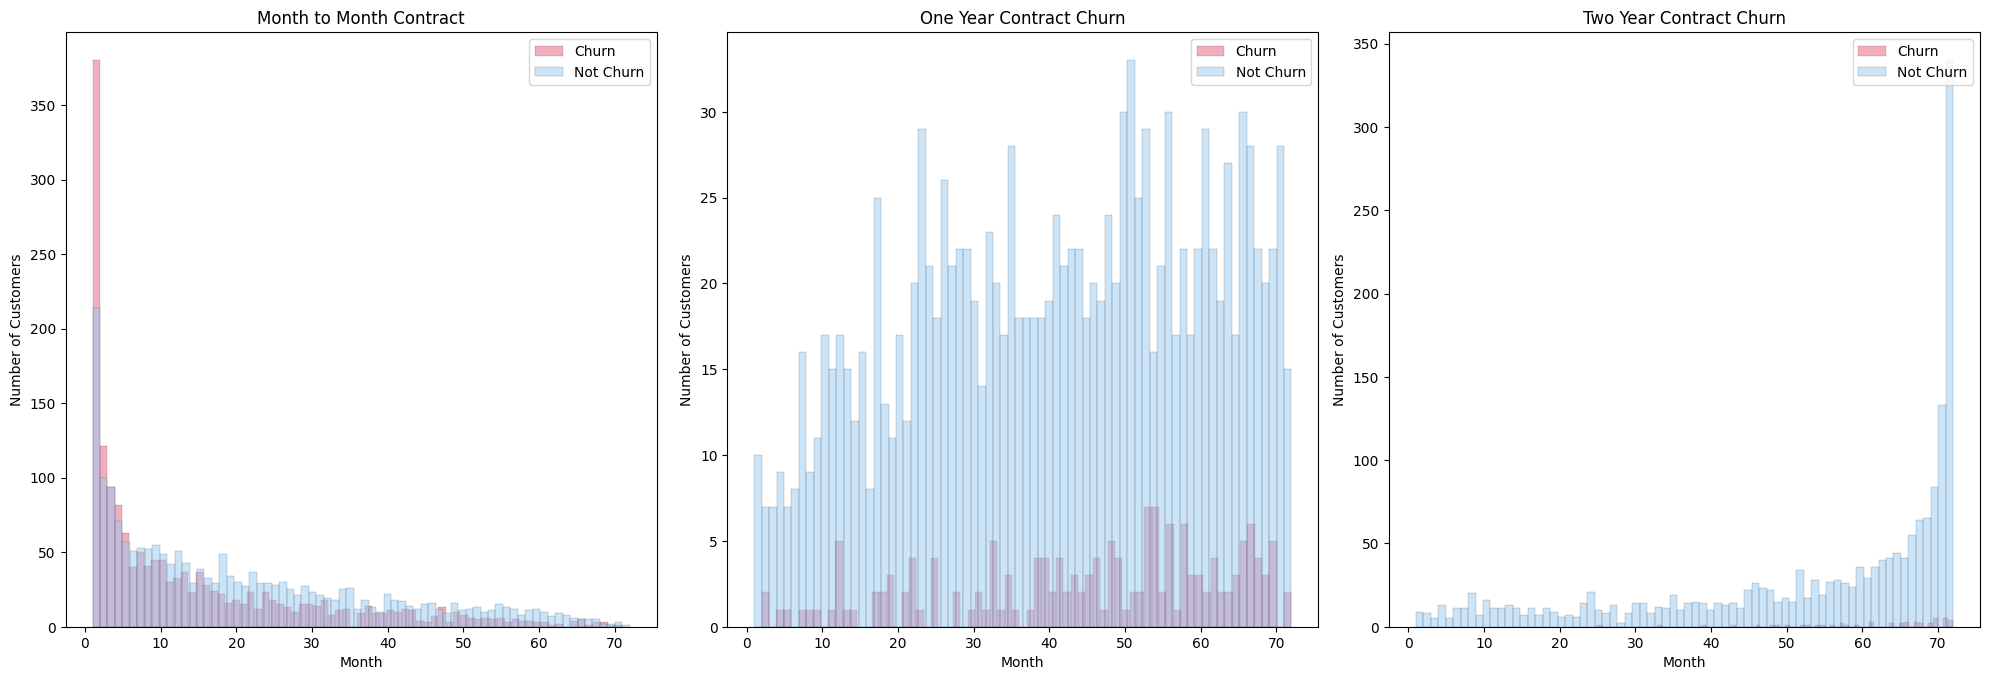

In [6]:
df_churn = df[df['Churn Value'] == 1]
df_not_churn = df[df['Churn Value'] == 0]

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 13))

# Plot on the first subplot
sns.histplot(df_churn[df_churn['Contract'] == 'Month-to-Month']['Tenure in Months'], bins=72, color='#EC8DA3', alpha=0.7, linewidth=0.1, ax=axs[0, 0])
sns.histplot(df_not_churn[df_not_churn['Contract'] == 'Month-to-Month']['Tenure in Months'], bins=72, color='#98CAF2', alpha=0.5, linewidth=0.1, ax=axs[0, 0])
axs[0, 0].legend(["Churn", "Not Churn"], loc="upper right")
axs[0, 0].set_ylabel('Number of Customers')
axs[0, 0].set_xlabel('Month')
axs[0, 0].set_title('Month to Month Contract')

# Plot on the second subplot
sns.histplot(df_churn[df_churn['Contract'] == 'One Year']['Tenure in Months'], bins=72, color='#EC8DA3', alpha=0.7, linewidth=0.1, ax=axs[0, 1])
sns.histplot(df_not_churn[df_not_churn['Contract'] == 'One Year']['Tenure in Months'], bins=72, color='#98CAF2', alpha=0.5, linewidth=0.1, ax=axs[0, 1])
axs[0, 1].legend(["Churn", "Not Churn"], loc="upper right")
axs[0, 1].set_ylabel('Number of Customers')
axs[0, 1].set_xlabel('Month')
axs[0, 1].set_title('One Year Contract Churn')

# Plot on the third subplot
sns.histplot(df_churn[df_churn['Contract'] == 'Two Year']['Tenure in Months'], bins=72, color='#EC8DA3', alpha=0.7, linewidth=0.1, ax=axs[0, 2])
sns.histplot(df_not_churn[df_not_churn['Contract'] == 'Two Year']['Tenure in Months'], bins=72, color='#98CAF2', alpha=0.5, linewidth=0.1, ax=axs[0, 2])
axs[0, 2].legend(["Churn", "Not Churn"], loc="upper right")
axs[0, 2].set_ylabel('Number of Customers')
axs[0, 2].set_xlabel('Month')
axs[0, 2].set_title('Two Year Contract Churn')

# Hide the unused subplots
for i in range(3, 6):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

### Key Findings

* From the first figure, a lot of customers churned after just a month.
* A lot of customers are with the provider for 72 months.
* The longer the contract, the longer customer stays with the provider.

## <b><span style='color:#645f89'>3.6</span> | Categorical Features vs Target Variable (Churn)</b>

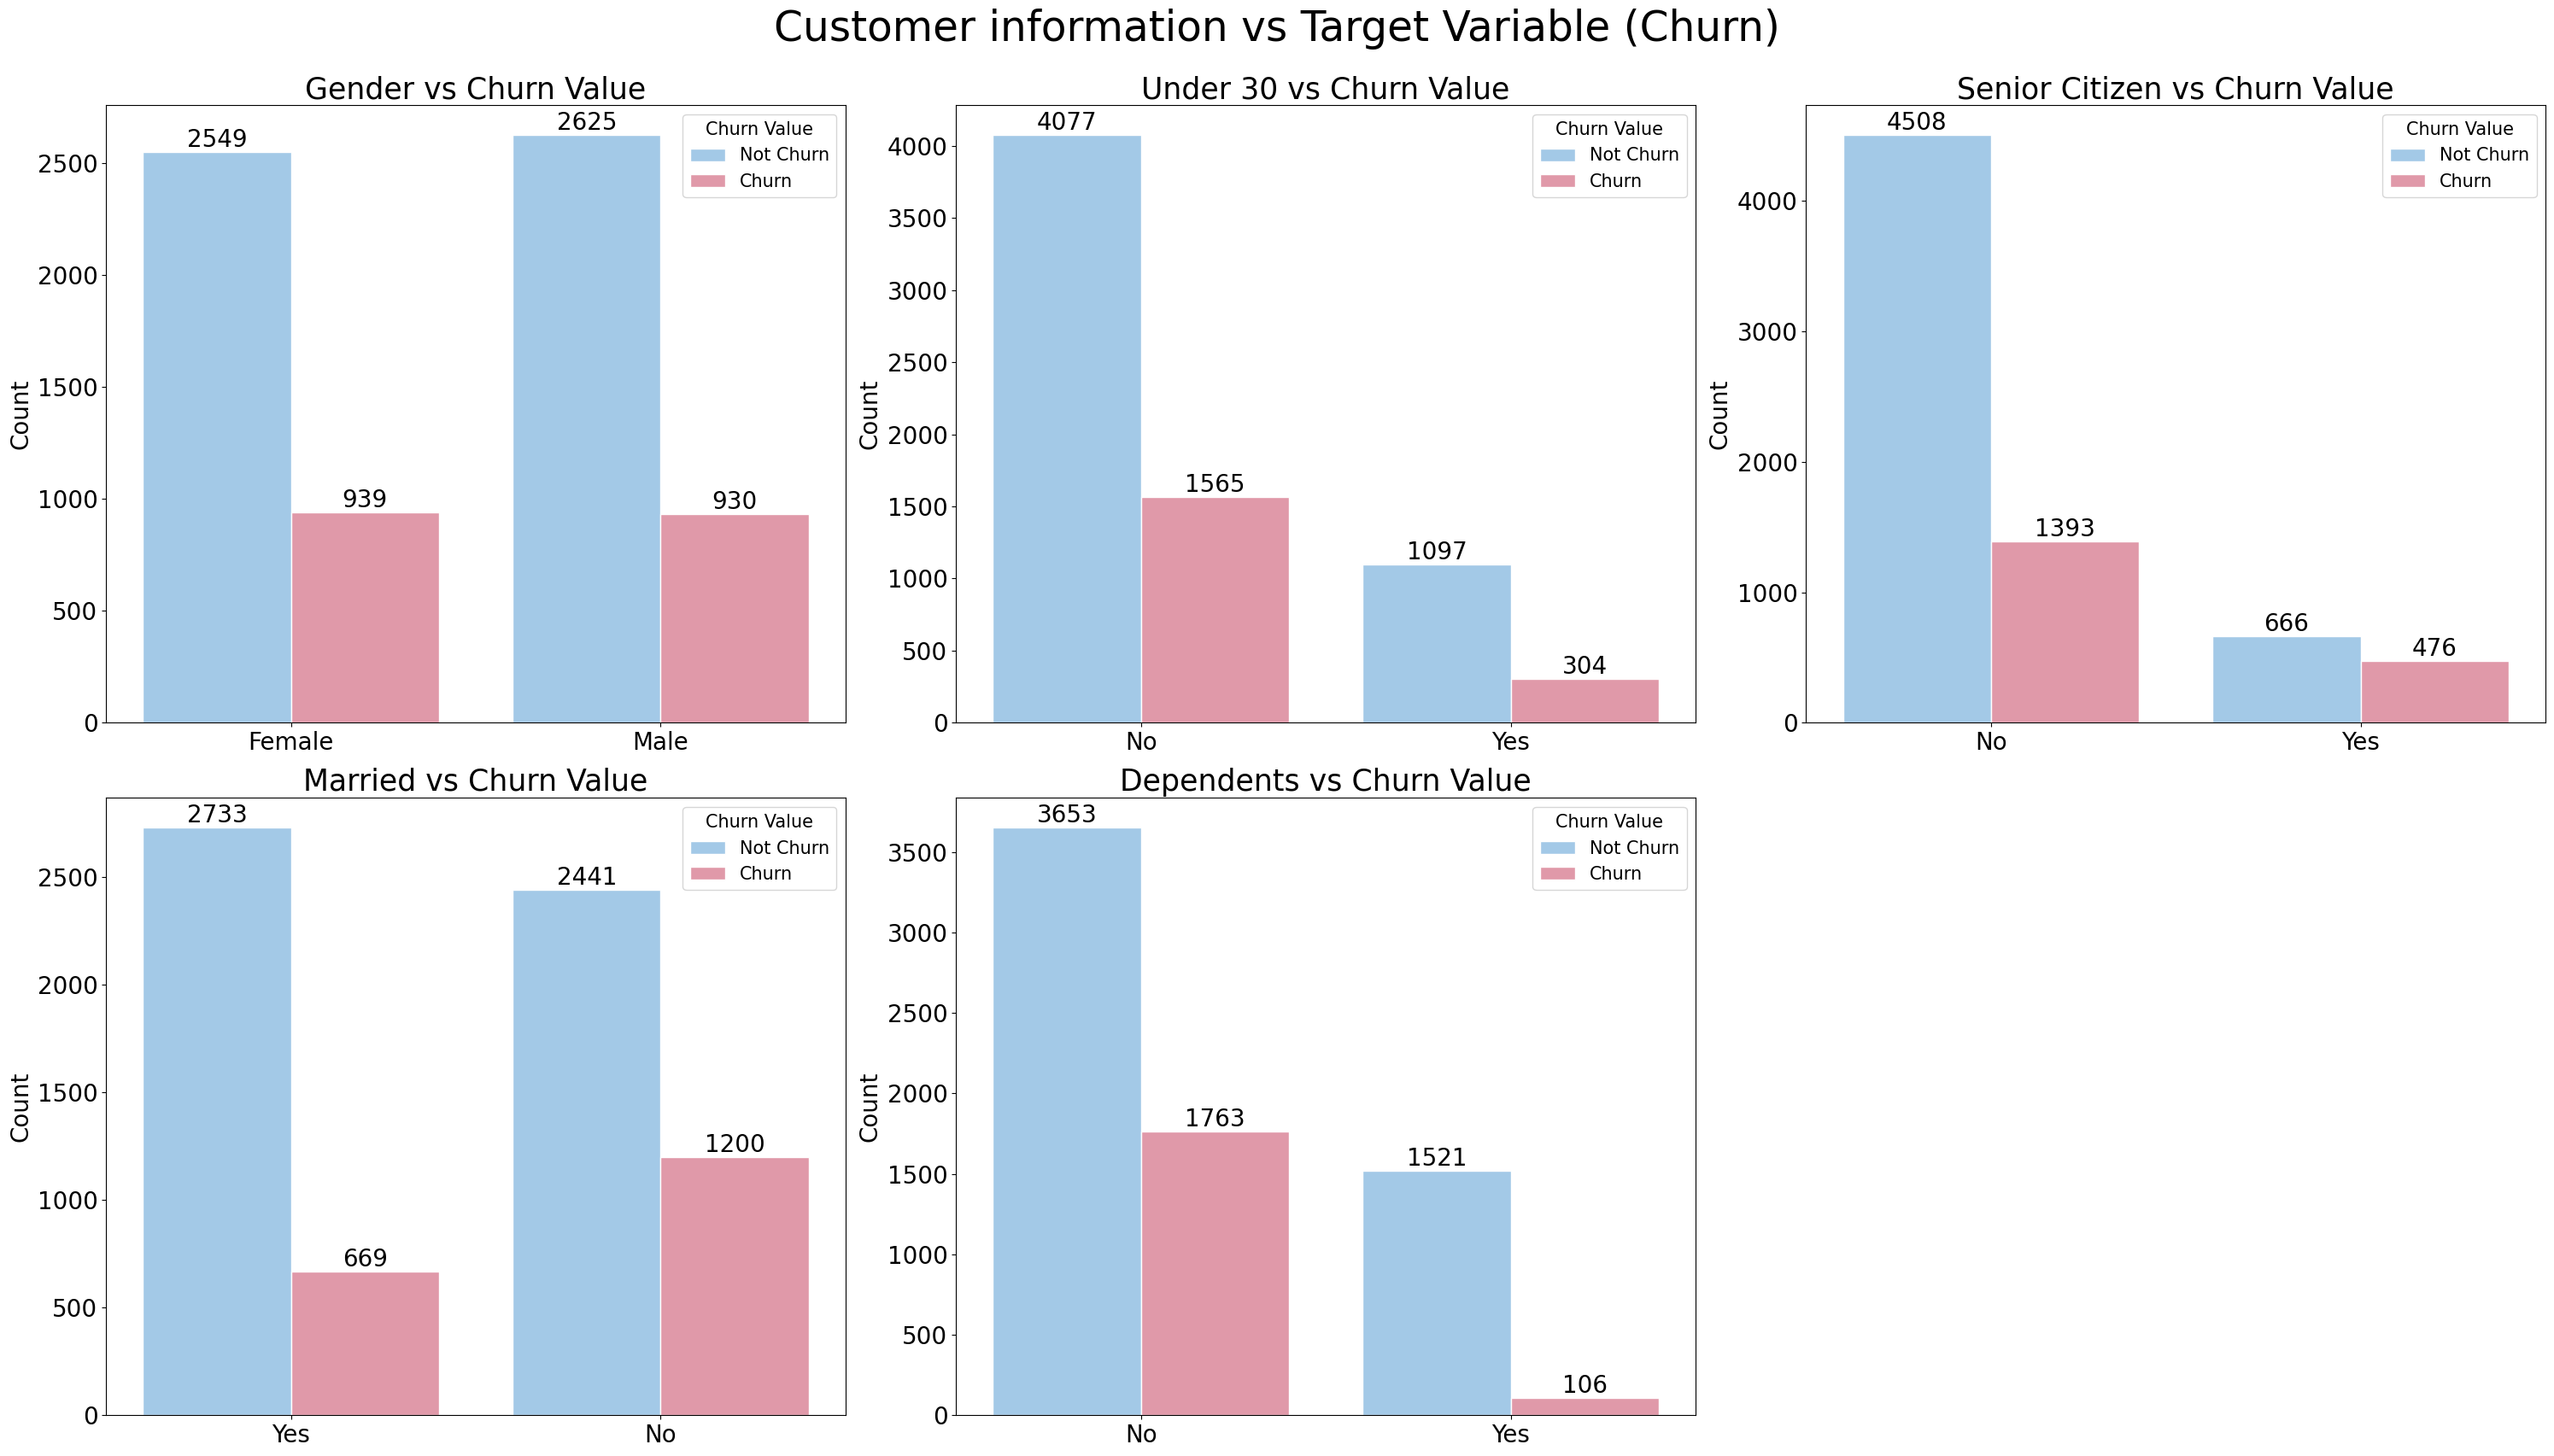

In [7]:
# We compared the `demographics` between churn and not churn groups. 

list1 = ['Gender', 'Under 30', 'Senior Citizen', 'Married', 'Dependents']
hue = "Churn Value"
figsize = (30,17)

def countplots_custom(dataset, columns_list, rows, cols, figsize, suptitle, hue, palette):
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(suptitle, y=1, size=35)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        ax = sns.countplot(data=dataset, ax=axs[i], x=columns_list[i], hue=hue, palette=palette, edgecolor='white')
        axs[i].set_title(data + f' vs {hue}', size=25)
        for i in ax.containers:
            ax.bar_label(i, size=20)
            ax.set_xlabel('')
            ax.tick_params(axis='y', labelsize=20)
            ax.set_ylabel('Count', fontsize=20)
            ax.tick_params(axis='x', labelsize=20)
            ax.legend(['Not Churn', 'Churn'], title = 'Churn Value', fontsize=15, title_fontsize=15)
            
countplots_custom(dataset=df, columns_list=list1, rows=2, cols=3, figsize=figsize, hue=hue, palette=palette, suptitle='Customer information vs Target Variable (Churn)')
plt.subplot(2,3,6).axis('off')
plt.tight_layout()

### Key Findings

* The correlation between gender and churn is weak. 
* Much more interesting is with 'Under 30', 'Senior Citizen', 'Married', 'Dependents’.

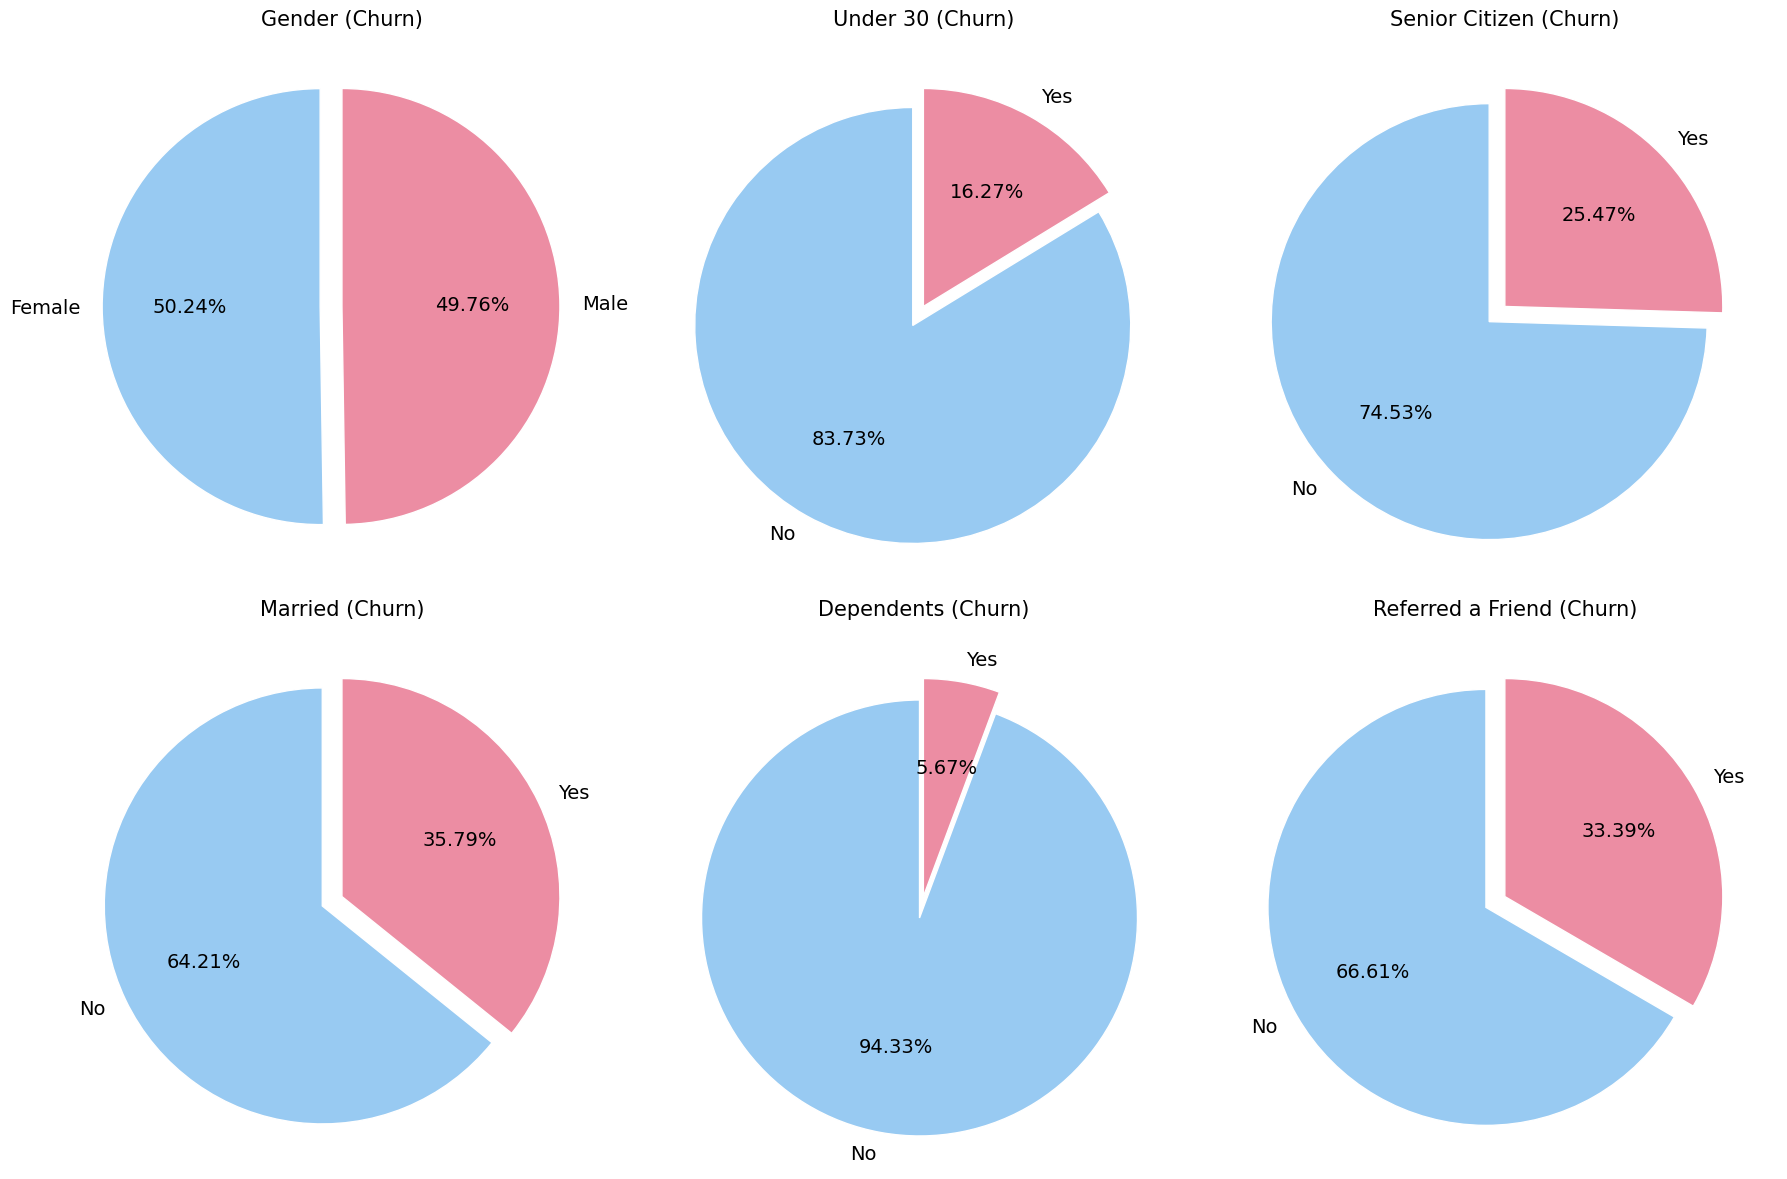

In [8]:
def calculate_pie_values(df, column, churn_value=1):
    counts = df[df['Churn Value'] == churn_value][column].value_counts()
    return [count / sum(counts) * 100 for count in counts]

pie_values1 = calculate_pie_values(df, 'Gender')
pie_values2 = calculate_pie_values(df, 'Under 30')
pie_values3 = calculate_pie_values(df, 'Senior Citizen')
pie_values4 = calculate_pie_values(df, 'Married')
pie_values5 = calculate_pie_values(df, 'Dependents')
pie_values6 = calculate_pie_values(df, 'Referred a Friend')


# Pie chart labels and titles
labels = [['Female', 'Male'], ['No', 'Yes'], ['No', 'Yes'], ['No', 'Yes'], ['No', 'Yes'], ['No', 'Yes']]
titles = ['Gender (Churn)', 'Under 30 (Churn)', 'Senior Citizen (Churn)', 'Married (Churn)', 'Dependents (Churn)', 'Referred a Friend (Churn)']
pie_values = [pie_values1, pie_values2, pie_values3, pie_values4, pie_values5, pie_values6]

# Create figure and axes
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

for i, ax in enumerate(axs.flatten()):
    ax.pie(pie_values[i], labels=labels[i], textprops={'fontsize': 14}, autopct='%1.2f%%', 
           startangle=90, explode=(0.1, 0), colors=palette, 
           wedgeprops={'edgecolor': 'white', 'linewidth': 1, 'antialiased': True})
    ax.set_title(titles[i], size=15)

plt.tight_layout()
plt.show()

### Key Findings

* Overall, customers whose age is between 30 – 65 are more likely to churn than senior citizens and customers under 30 years old.
* Those without partners churn slightly more than those with partners.
* Customers with dependents churn less than those without dependents.

# <div style="color:white;display:fill;border-radius:5px;background-color:#645f89;font-family:Arial;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;letter-spacing:0.5px;margin:0"><b>4 |</b> Data Preprocessing</p></div>

## <b><span style='color:#645f89'>4.1</span> | Missing Data</b>

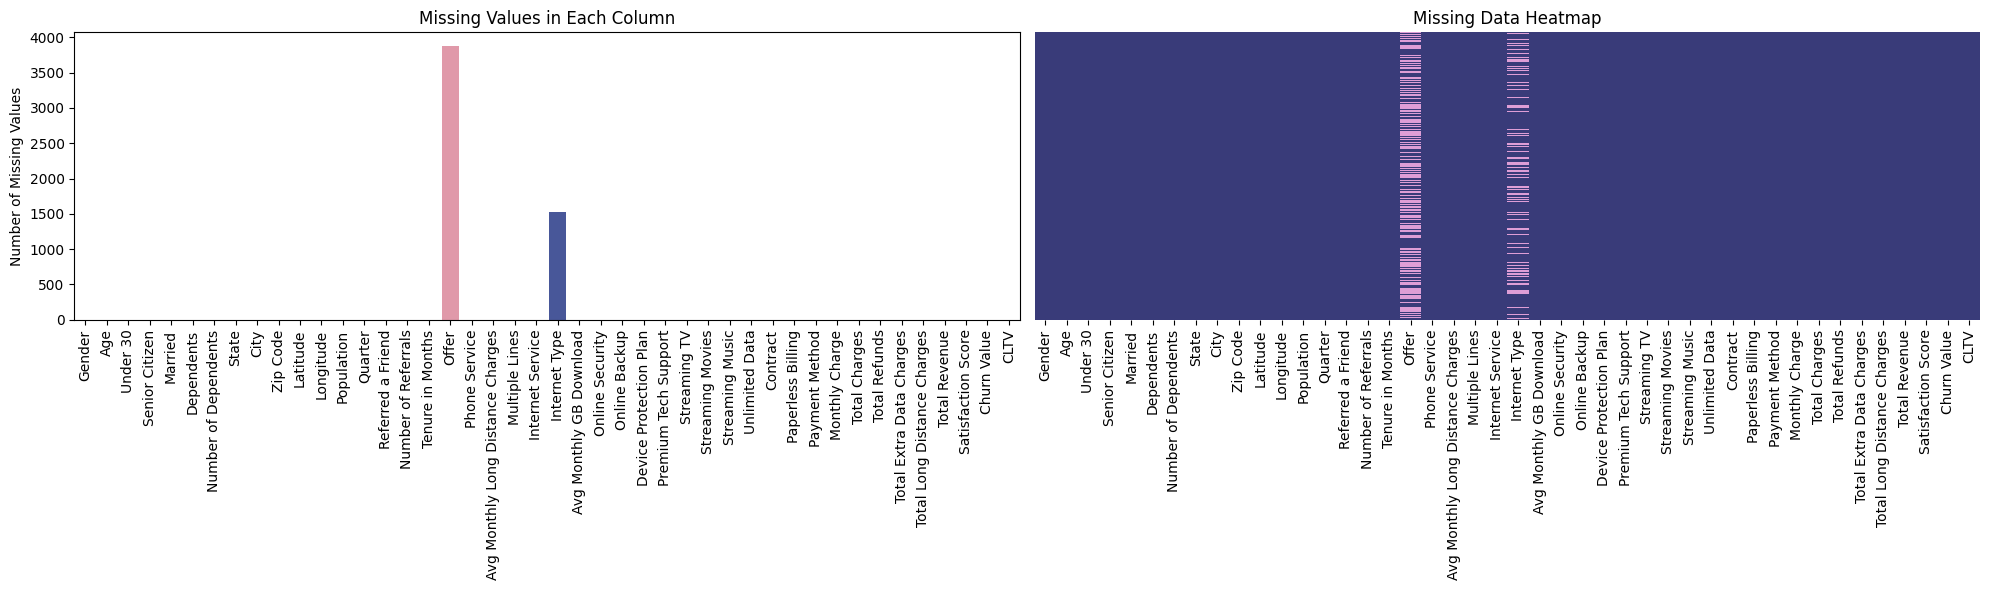

In [9]:
# Remove useless columns
df.drop(columns=['Churn Reason', 'Churn Category', 'Churn Score', 'Churn Label', 
                 'Customer Status', 'Status ID', 'Service ID', 'Lat Long', 'Country', 
                 'Location ID', 'Count', 'Customer ID'], axis=1, inplace=True)

missing_values = df.isnull().sum()

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 6))  # Adjust the overall figure size

# Bar plot of missing values in the first subplot
sns.barplot(x=missing_values.index, y=missing_values, palette=palette, ax=ax[0])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylabel('Number of Missing Values')
ax[0].set_title('Missing Values in Each Column')

# Heatmap of missing values in the second subplot
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='tab20b', ax=ax[1])
ax[1].set_title('Missing Data Heatmap')

# Adjust layout
plt.tight_layout()
plt.show()

In [10]:
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(pd.crosstab(df['Offer'], df['Churn Value']))
print(chi2, p_value)

chi2_2, p_value_2, dof_2, expected_2 = chi2_contingency(pd.crosstab(df['Internet Type'], df['Churn Value']))
print(chi2_2, p_value_2)

488.63580941016255 1.922256787519315e-104
258.81066438274036 6.309258194179288e-57


### Key Findings

* `Offer` has a missing value ratio over 50%. 
* `Internet Type` has a missing value ratio of around 20%
* Based on Chi-Square Test (for binary vs categorical) results, both `Offer` and `Internet Type` are important (p<0.05).
* Therefore, **I will use a placeholder value 'Unknown' to impute `Offer`, use mode imputation for `Internet Type`.**

In [11]:
# Impute 'Offer' with 'Unknown'
df['Offer'] = df['Offer'].fillna('Unknown')

# Impute 'Internet Type' with its mode
mode_internet_type = df['Internet Type'].mode()[0]  # The mode() method returns a series, so we take the first element
df['Internet Type'] = df['Internet Type'].fillna(mode_internet_type)

missing_values = df.isnull().sum()
missing_values

Gender                               0
Age                                  0
Under 30                             0
Senior Citizen                       0
Married                              0
Dependents                           0
Number of Dependents                 0
State                                0
City                                 0
Zip Code                             0
Latitude                             0
Longitude                            0
Population                           0
Quarter                              0
Referred a Friend                    0
Number of Referrals                  0
Tenure in Months                     0
Offer                                0
Phone Service                        0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Service                     0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup            

## <b><span style='color:#645f89'>4.2</span> | Class Imbalance - SMOTE</b>

Our target variable, `Churn`, is quite imbalanced with a little over 26% (1,869 customers) leaving the company within the past month. Since class imbalance can negatively affect the precision and recall accuracy of statistical models, I will use a **S**ynthetic **M**inority **O**ver-sampling **TE**chnique known as **[SMOTE](https://rdrr.io/cran/performanceEstimation/man/smote.html)** to create a more evenly distributed training set. 

The `SMOTE` algorithm artificially generates new instances of the minority class using the nearest neighbors of these cases and under-samples the majority class to create a more balanced data set. After applying `SMOTE`, our training set now consists of an equal proportion of current and former customers.

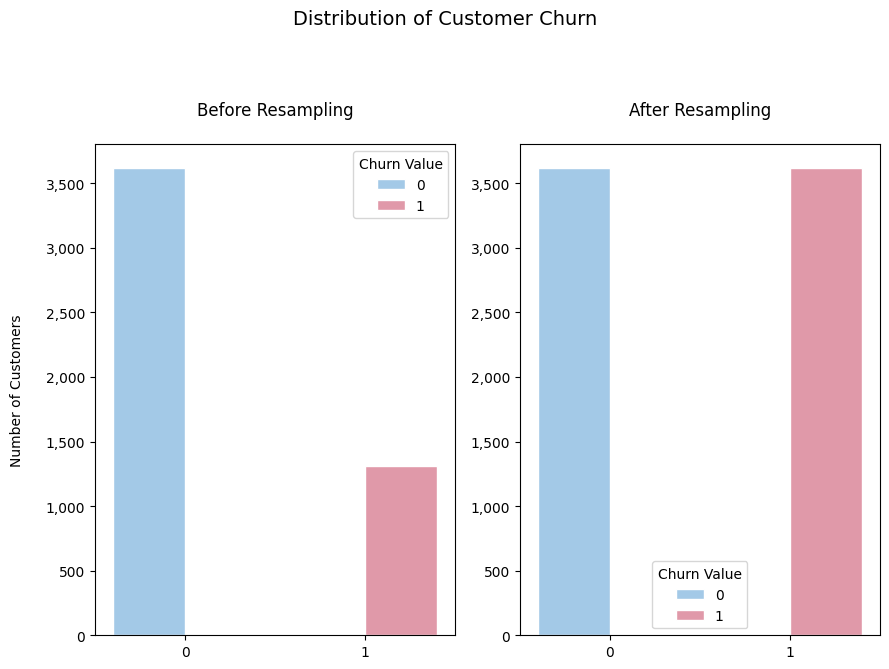

In [12]:
from imblearn.over_sampling import SMOTE
from matplotlib.ticker import FuncFormatter

# Encoding categorical variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Splitting Data
train, test = train_test_split(df_encoded, test_size=0.3, random_state=1, stratify=df_encoded['Churn Value'])

# SMOTE Resampling
sm = SMOTE(sampling_strategy='auto', random_state=1)
X_train_res, y_train_res = sm.fit_resample(train.drop('Churn Value', axis=1), train['Churn Value'])
train_resamp = pd.concat([X_train_res, y_train_res], axis=1)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(9, 7))

# Before Resampling
sns.countplot(x='Churn Value', data=train, ax=ax[0], hue=hue, palette=palette, edgecolor='white')
ax[0].set_title('Before Resampling\n')
ax[0].set_xlabel('')
ax[0].set_ylabel('Number of Customers\n')

# After Resampling
sns.countplot(x='Churn Value', data=train_resamp, ax=ax[1], hue=hue, palette=palette, edgecolor='white')
ax[1].set_title('After Resampling\n')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

# Format y-axis labels with commas
formatter = FuncFormatter(lambda x, _: '{:,}'.format(int(x)))
ax[0].yaxis.set_major_formatter(formatter)
ax[1].yaxis.set_major_formatter(formatter)

plt.suptitle('Distribution of Customer Churn\n', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# <div style="color:white;display:fill;border-radius:5px;background-color:#645f89;font-family:Arial;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;letter-spacing:0.5px;margin:0"><b>5 |</b> Feature Selection</p></div>

To identify which features should be included in the models, I will use a three-step process. First, I will check the chi-squared tests of independence between the categorical features and include only variables that have a statistically significant association to our response, `Churn`. Then, I will use the Point-Biserial Correlation to check the relationship between target variable `Churn` and numerical variables. Finally, I will use the random forests algorithm to identify the most important predictors of customer churn. 

## <b><span style='color:#645f89'>5.1</span> | Chi-Squared Tests</b>
The Chi-Squared Test of Independence evaluates the association between two categorical variables. The null hypothesis for this test is that there is no relationship between our response variable and the categorical feature, and the alternative hypothesis is that that there is a relationship. 

In [13]:
from scipy.stats import chi2_contingency

# Selecting all categorical columns except the target variable
categorical_cols = df.select_dtypes(include=['category', 'object']).columns

# Function to perform chi-squared test
def perform_chi2_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    return chi2, p_value

# Applying the function to each categorical column
chi2_results = {col: perform_chi2_test(df, col, 'Churn Value') for col in categorical_cols}

# Creating a DataFrame from the results
chi2_df = pd.DataFrame(chi2_results, index=['chi2', 'p_value']).T

# Sorting the DataFrame by p-value and rounding the values
chi2_df = chi2_df.sort_values(by='p_value').round(3)

chi2_df

,chi2,p_value
Contract,1445.293,0.000
Offer,481.725,0.000
Dependents,433.734,0.000
Internet Service,364.520,0.000
Payment Method,337.831,0.000
Paperless Billing,258.278,0.000
Online Security,205.633,0.000
Unlimited Data,194.549,0.000
Premium Tech Support,190.167,0.000
Senior Citizen,159.426,0.000


### Key Findings
Looking at the results of the tests, `Gender`, `PhoneService`, `Quarter`, `State` have very small chi-squared statistics and p-values that are greater than the significance threshold, $a$, of 0.05, indicating they are independent of our target variable. The rest of the categorical features do have a statistically significant association to customer churn.

## <b><span style='color:#645f89'>5.2</span> | Point-Biserial Correlation</b>
Point-Biserial Correlation is a measure of the relationship between a binary variable and a continuous or ordinal numerical variable. It's a special case of Pearson's correlation coefficient. The correlation value ranges from -1 to 1, where values closer to -1 or 1 indicate a stronger relationship. The p-value indicates the statistical significance of the correlation.

In [14]:
from scipy.stats import pointbiserialr

# Selecting all numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols[numerical_cols != 'Churn Value']

# Initialize a dictionary to hold the results
correlation_results = {}

# Iterate over each numerical column and calculate point-biserial correlation
for col in numerical_cols:
    correlation, p_value = pointbiserialr(df['Churn Value'], df[col])
    correlation_results[col] = {'correlation': correlation, 'p_value': p_value}

# Convert the results dictionary to a DataFrame for easier viewing
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index')

# Print the results DataFrame
print(correlation_df)

                                   correlation        p_value
Age                                   0.115760   1.920497e-22
Number of Dependents                 -0.218780   4.420027e-77
Zip Code                             -0.016289   1.716809e-01
Latitude                             -0.041546   4.874845e-04
Longitude                             0.024052   4.354771e-02
Population                            0.051655   1.443406e-05
Number of Referrals                  -0.286540  3.406199e-133
Tenure in Months                     -0.352861  1.329222e-205
Avg Monthly Long Distance Charges     0.008120   4.956803e-01
Avg Monthly GB Download               0.048868   4.081545e-05
Monthly Charge                        0.193356   2.706646e-60
Total Charges                        -0.198546   1.538899e-63
Total Refunds                        -0.033709   4.665343e-03
Total Extra Data Charges              0.007139   5.491321e-01
Total Long Distance Charges          -0.223756   1.247019e-80
Total Re

### Key Findings
Looking at the results of the tests, `Zip Code`, `Avg Monthly Long Distance Charges`, `Total Extra Data Charges`, `State`, their p-values that are greater than the significance threshold, $a$, of 0.05, indicating they are independent of our target variable. The rest of the numerical features do have a statistically significant association to customer churn.

## <b><span style='color:#645f89'>5.3</span> | Pearson Correlation </b>

* This is the most common method for measuring the correlation between two continuous numerical variables.
* The Pearson correlation coefficient ranges from -1 to 1. A value close to 1 implies a strong positive correlation (as one variable increases, so does the other), a value close to -1 implies a strong negative correlation (as one variable increases, the other decreases), and a value around 0 implies no correlation.

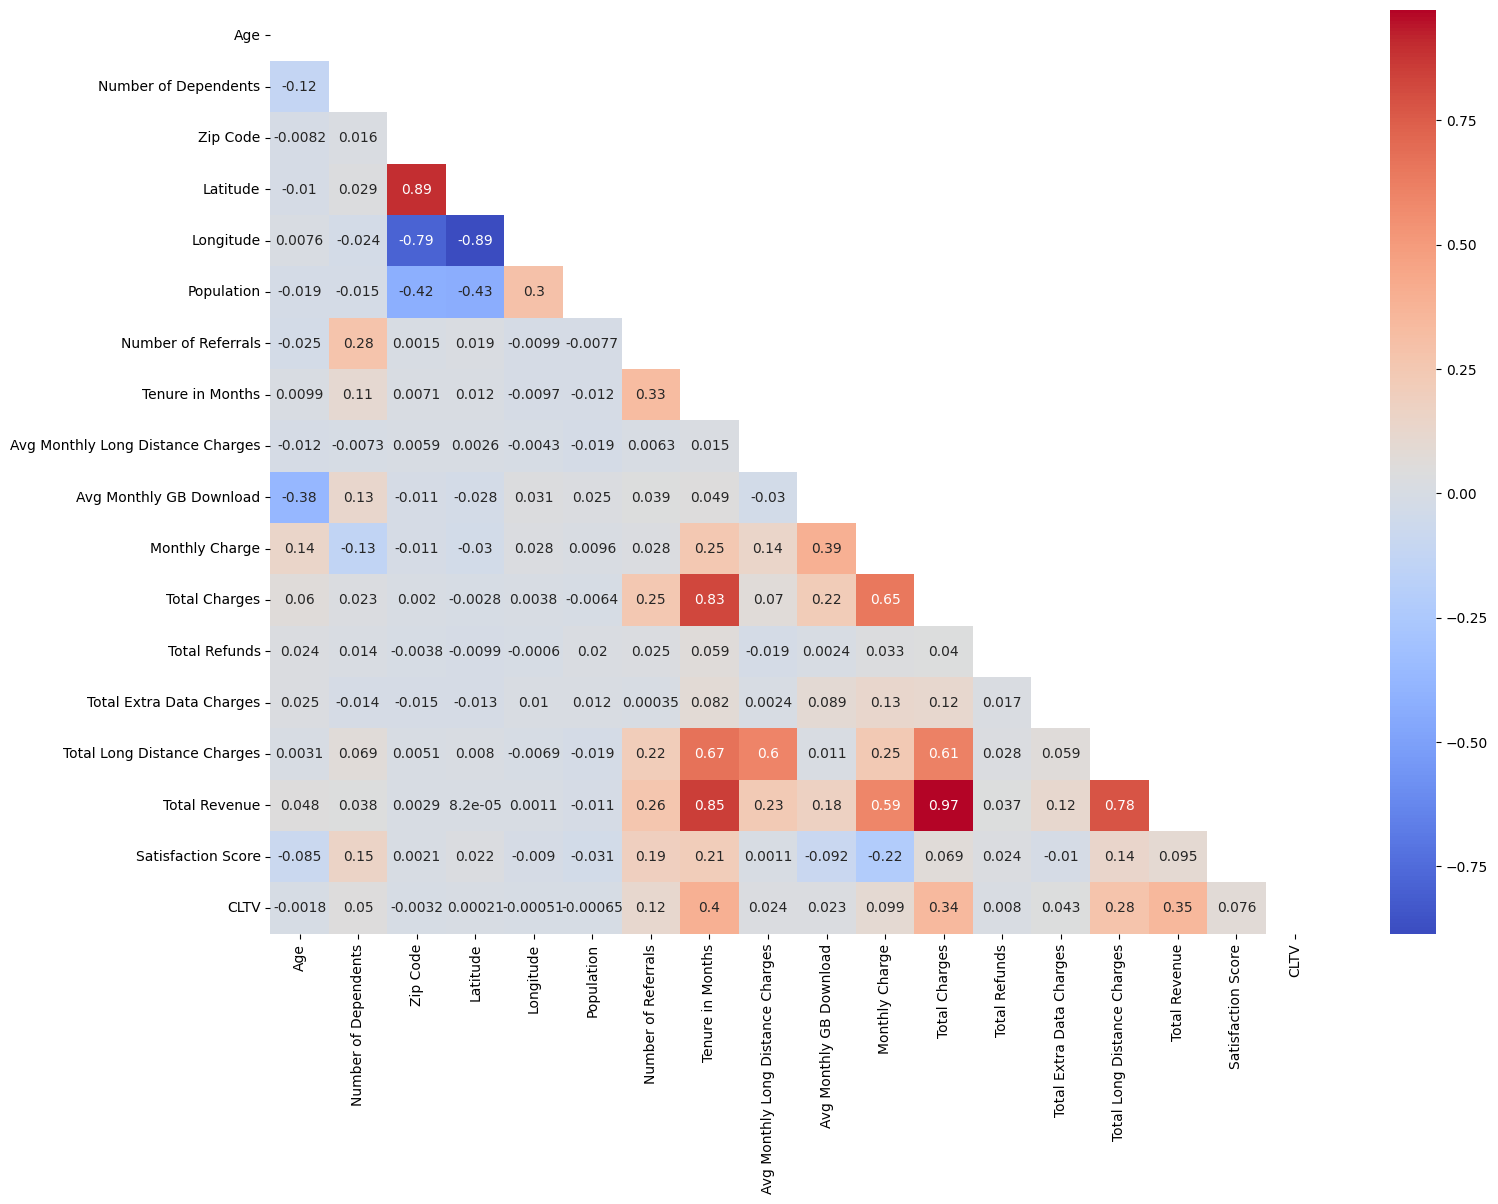

In [15]:
# Calculate the pairwise Pearson correlation of numerical variables
correlation_matrix = df[numerical_cols].corr(method='pearson')

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plotting the heatmap
plt.figure(figsize=(17, 12))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm')
plt.show()

### Key Findings
* `Total Revenue`, `Total Charges`, `Tenure in Months` have high correlation coefficients.
* We might need to only keep one of them for the model building.

## <b><span style='color:#645f89'>5.4</span> | Feature Importance</b>

The random forest algorithm uses two measures in calculating variable importance, mean decrease in Gini and mean decrease in accuracy. The [mean decrease in Gini](https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/importance) is the total decrease in node impurities from splitting on the variable measured by the Gini index, averaged over all trees in the model. The [mean decrease in accuracy](https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/importance), also called permutation importance, measures the average decrease in prediction accuracy when the values of each variable are randomly permuted in the out-of-bag samples.

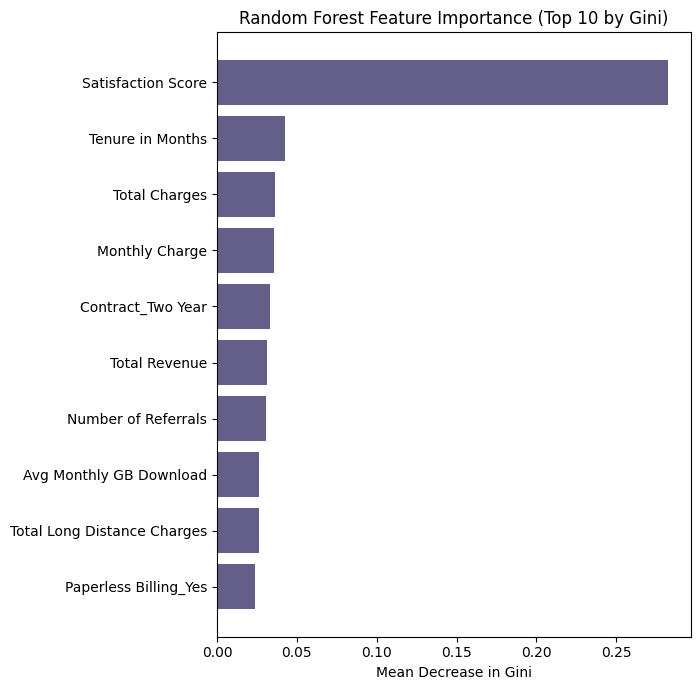

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
X_scaled_train_res = scaler.fit_transform(X_train_res)

# Create and fit the model
rf = RandomForestClassifier(random_state=1)
rf.fit(X_scaled_train_res, y_train_res)

feature_importances = pd.DataFrame({'feature': X_train_res.columns, 
                                    'importance': rf.feature_importances_})


# Sort features by importance
top_gini = feature_importances.sort_values(by='importance', ascending=False).head(10)

# Plotting
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.title('Random Forest Feature Importance (Top 10 by Gini)')
plt.barh(top_gini['feature'], top_gini['importance'], color='#645f89')
plt.xlabel('Mean Decrease in Gini')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

Due to `Total Revenue` and `Total Charges` has collinearity with `Tenure in Months`, all of the features except for `Total Revenue` and `Total Charges` will be selected as predictors in the models.

# <div style="color:white;display:fill;border-radius:5px;background-color:#645f89;font-family:Arial;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;letter-spacing:0.5px;margin:0"><b>6 |</b> Predicting Customer Churn</p></div>

## <b><span style='color:#645f89'>6.1</span> | Methodology</b>
To predict which customers are most likely to churn, several different types of classification models will be evaluated, including logistic regression, Gradient Boosting Machines (GBM), support vector machines, random forests, K-Nearest Neighbors (KNN), Naive Bayes. 

Since the numeric predictors, `Monthly Charges` and `Tenure in Months`, have skewed distributions and varying scales, I will apply a preprocessing technique that normalizes the features to have a mean of 0 and a standard deviation of 1. 

To fit the models, 5-fold cross-validation will be used and the model will be tested on the out of sample dataset. This set was held out of resampling and is more representative of the true class distribution.

## <b><span style='color:#645f89'>6.2</span> | Logistic Regression</b>

Logistic regression is a parametric classification technique that estimates the probability of an event occurring, for instance, whether or not a customer will leave the company. One of the advantages of the logistic model is the interpretability of the model parameters. Based on the size of the coefficients and the significance of the predictors, the model is able to quantify the relationships between our response and the input features.

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

features = ['Satisfaction Score', 'Tenure in Months', 'Monthly Charge', 'Contract_Two Year', 'Avg Monthly GB Download', 
            'Number of Referrals', 'Total Long Distance Charges', 'Paperless Billing_Yes']
X_train_res = train_resamp[features]
y_train_res = train_resamp['Churn Value']
X_test = test[features]
y_test = test['Churn Value']

# Standardize the features
scaler = StandardScaler()

# Fit the scaler on the resampled training data and transform
X_train_res_scaled = scaler.fit_transform(X_train_res)

# Transform the test data features
X_test_scaled = scaler.transform(X_test)

# Create and fit the logistic regression model
lr = LogisticRegression()
lr.fit(X_train_res_scaled, y_train_res)

# Make predictions on the test set
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]  # Probabilities for ROC AUC

# Evaluate the model
cm = confusion_matrix(test['Churn Value'], y_pred)
roc_auc = roc_auc_score(test['Churn Value'], y_proba)
report = classification_report(test['Churn Value'], y_pred)

print("Confusion Matrix:\n", cm)
print("\nROC AUC Score:", roc_auc)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[1490   62]
 [  64  497]]

ROC AUC Score: 0.9857007001488505

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1552
           1       0.89      0.89      0.89       561

    accuracy                           0.94      2113
   macro avg       0.92      0.92      0.92      2113
weighted avg       0.94      0.94      0.94      2113



The logistic regression model has an overall accuracy of 94% and a precision of 94% on the test set. This means that when the model predicts a customer will leave, it is correct around 94% of the time. The recall of our model is 94%, which means that it correctly identified about 94% of all customers who left.

### <b><span style='color:#645f89'>6.2.1</span> | Multicollinearity</b>

One of the assumptions of logistic regression is that the predictors are not too highly correlated with each other. The Variance Inflation Factor (VIF) measures the amount of multicollinearity between the features in the model. A general rule of thumb is a VIF score of no higher than between 5 and 10.

In [18]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

numerical_col= [ "Number of Referrals", "Tenure in Months", 
                   "Avg Monthly GB Download", "Monthly Charge", "Total Refunds", 
                   "Total Long Distance Charges" 
                   ]

X = df[numerical_col] # VIF is typically calculated for continuous variables. 
X = sm.add_constant(X)  # Adds an intercept term

# Function to calculate VIF for each feature
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Calculate VIF
vif_df = calculate_vif(X)

# Sort the VIF values in descending order
vif_df = vif_df.sort_values(by="VIF", ascending=False)
print(vif_df)

                       feature       VIF
0                        const  6.507036
2             Tenure in Months  1.992145
6  Total Long Distance Charges  1.868562
4               Monthly Charge  1.289411
3      Avg Monthly GB Download  1.195573
1          Number of Referrals  1.126412
5                Total Refunds  1.004371


### Key Findings

Since the majority of the predictors have a VIF of less than 5 and none exceed 10, there doesn't exist multicollinearity.

## <b><span style='color:#645f89'>6.3</span> | Extreme Gradient Boosting (XGBoost)</b>

XGBoost stands for eXtreme Gradient Boosting. It is an advanced implementation of gradient boosting algorithm.
It has gained popularity in machine learning competitions and practical applications due to its efficiency, scalability, and effectiveness.

In [21]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit the classifier to the training data
xgb_clf.fit(X_train_res, y_train_res)

# Predicting the Test set results
y_pred = xgb_clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

Accuracy: 94.04%
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1552
           1       0.89      0.88      0.89       561

    accuracy                           0.94      2113
   macro avg       0.93      0.92      0.92      2113
weighted avg       0.94      0.94      0.94      2113



## <b><span style='color:#645f89'>6.4</span> | Support Vector Machines (SVM)</b>

Support vector machines (SVMs) are a commonly used statistical learning model. It is nonparametric, which means that it does not make any assumptions about the data like logistic regression does. SVMs involve finding a hyperplane that separates the data as well as possible and maximizes the distance between the classes of our response variable.

In [43]:
from sklearn.svm import SVC

# Initialize the SVM classifier
svm_clf = SVC(probability=True, random_state=42)

# Fit the classifier to the training data
svm_clf.fit(X_train_res, y_train_res)

# Predicting the Test set results
y_pred = svm_clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

Accuracy: 71.70%
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1552
           1       0.48      0.73      0.58       561

    accuracy                           0.72      2113
   macro avg       0.68      0.72      0.68      2113
weighted avg       0.77      0.72      0.73      2113



## <b><span style='color:#645f89'>6.5</span> | Random Forest</b>
​
Random forest is a commonly used ensemble technique in machine learning. The model is built using a combination of many decision trees, where each takes a random sample of the data with replacement and selects a random subset of predictors, resulting in a relatively uncorrelated set of decision trees. Each tree then makes a prediction and the class with the most votes becomes the model's final prediction.

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Fit the classifier to the training data
rf_clf.fit(X_train_res, y_train_res)

# Predicting the Test set results
y_pred = rf_clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

Accuracy: 94.94%
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1552
           1       0.91      0.89      0.90       561

    accuracy                           0.95      2113
   macro avg       0.94      0.93      0.93      2113
weighted avg       0.95      0.95      0.95      2113



## <b><span style='color:#645f89'>6.6</span> | K-Nearest Neighbors (KNN)</b>

A non-parametric method that classifies a data point based on how its neighbors are classified.

In [31]:
from sklearn.neighbors import KNeighborsClassifier

# Scaling features
scaler = StandardScaler()
X_train_res_stand = scaler.fit_transform(X_train_res)
X_test_stand = scaler.transform(X_test)

# Initialize the KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier to the training data
knn_clf.fit(X_train_res_stand, y_train_res)

# Predicting the Test set results
y_pred = knn_clf.predict(X_test_stand)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 93.37%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      1552
           1       0.89      0.86      0.87       561

    accuracy                           0.93      2113
   macro avg       0.92      0.91      0.91      2113
weighted avg       0.93      0.93      0.93      2113



## <b><span style='color:#645f89'>6.7</span> | Naive Bayes</b>

A probabilistic classifier based on applying Bayes' theorem with strong independence assumptions.

In [34]:
from sklearn.naive_bayes import GaussianNB  

# Initialize the Naive Bayes classifier
nb_clf = GaussianNB()

# Fit the classifier to the training data
nb_clf.fit(X_train_res, y_train_res)

# Predicting the Test set results
y_pred = nb_clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 89.45%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      1552
           1       0.75      0.90      0.82       561

    accuracy                           0.89      2113
   macro avg       0.86      0.90      0.87      2113
weighted avg       0.90      0.89      0.90      2113



# <div style="color:white;display:fill;border-radius:5px;background-color:#645f89;font-family:Arial;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;letter-spacing:0.5px;margin:0"><b>7 |</b> Model Evaluation and ROC Curves</p></div>

## <b><span style='color:#645f89'>7.1</span> | Model Performance on the Test Set</b>

In [41]:
# Example metrics for each model
lr_metrics = {'F1': 0.94, 'Precision': 0.94, 'Recall': 0.94, 'Accuracy': 0.99}
xgb_metrics = {'F1': 0.94, 'Precision': 0.94, 'Recall': 0.94, 'Accuracy': 0.94}
svm_metrics = {'F1': 0.77, 'Precision': 0.72, 'Recall': 0.73, 'Accuracy': 0.72}
rf_metrics = {'F1': 0.95, 'Precision': 0.95, 'Recall': 0.95, 'Accuracy': 0.95}
knn_metrics = {'F1': 0.93, 'Precision': 0.93, 'Recall': 0.93, 'Accuracy': 0.94}
nb_metrics = {'F1': 0.90, 'Precision': 0.89, 'Recall': 0.90, 'Accuracy': 0.89}

# Combine into a DataFrame
res = pd.DataFrame({'LR': lr_metrics, 'XGB': xgb_metrics, 'SVM': svm_metrics, 'Random Forest': rf_metrics, 
                    'KNN': knn_metrics, 'NB': nb_metrics})

# Transposing the DataFrame
res = res.T

# Format values as percentages
res = res.applymap(lambda x: "{:.1f}%".format(x * 100))

# Sort by F1-score and select specific columns
res = res.sort_values(by='F1', ascending=False)[['F1', 'Precision', 'Recall', 'Accuracy']]

# Convert to DataFrame for display
final_res = pd.DataFrame(res)

final_res

,F1,Precision,Recall,Accuracy
Random Forest,95.0%,95.0%,95.0%,95.0%
LR,94.0%,94.0%,94.0%,99.0%
XGB,94.0%,94.0%,94.0%,94.0%
KNN,93.0%,93.0%,93.0%,94.0%
NB,90.0%,89.0%,90.0%,89.0%
SVM,77.0%,72.0%,73.0%,72.0%


### Key Findings
Out of the six models, Random Forest produces the highest [F1 score](https://en.wikipedia.org/wiki/F-score), which represents the balance between precision and recall, as well as the highest specificity, which measures how well the model identifies negative cases correctly. 

## <b><span style='color:#645f89'>7.2</span> | ROC Curves</b>

As a final step in model selection, I will plot the ROC curves of each model with their corresponding Area Under the Curve [(AUC)](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). The Area Under the Curve measures the model's performance across all possible classification thresholds. A higher AUC indicates the model is better able to distinguish between the classes. 

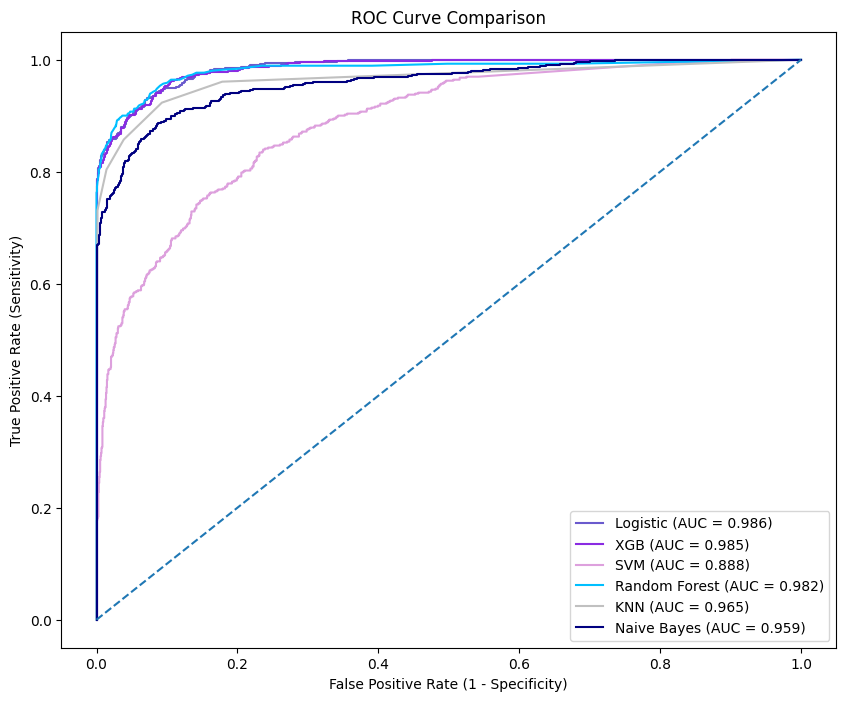

In [57]:
from sklearn.metrics import roc_curve, auc

logistic_probs = lr.predict_proba(X_test_scaled)[:, 1]
xgb_probs = xgb_clf.predict_proba(X_test)[:, 1]
svm_probs = svm_clf.predict_proba(X_test_scaled)[:, 1]  
random_forest_probs = rf_clf.predict_proba(X_test)[:, 1]
knn_probs = knn_clf.predict_proba(X_test_scaled)[:, 1]
nb_probs = nb_clf.predict_proba(X_test)[:, 1]

# Calculate ROC Curve and AUC for each model
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, logistic_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, random_forest_probs)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probs)

auc_logistic = auc(fpr_logistic, tpr_logistic)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_svm = auc(fpr_svm, tpr_svm)
auc_rf = auc(fpr_rf, tpr_rf)
auc_knn = auc(fpr_knn, tpr_knn)
auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(10, 8))

# Plot ROC curves
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic (AUC = {auc_logistic:.3f})', color='slateblue')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {auc_xgb:.3f})', color='blueviolet')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.3f})', color='plum')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', color='deepskyblue')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.3f})', color='silver')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.3f})', color='navy')

# Plot line with no predictive power (baseline)
plt.plot([0, 1], [0, 1], linestyle='--')


# Customize the plot
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()

# Show the plot
plt.show()

### Key Findings
* Out of the four classifiers, the Logistic Model has the highest Area Under the Curve of 0.986 on the test set. This represents the probability that our model will rate or rank a randomly chosen observation from the positive class, `Churn = Yes`, as more likely to be from that class than a randomly chosen nonpositive observation, `Churn = No` [(Hanley & McNeil, 1982)](https://pubs.rsna.org/doi/pdf/10.1148/radiology.143.1.7063747).
* Therefore, I will Logistic Model as the final model and do the hyperparameter tuning and optimization.

# <div style="color:white;display:fill;border-radius:5px;background-color:#645f89;font-family:Arial;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;letter-spacing:0.5px;margin:0"><b>8 |</b> Hyperparameter tuning and optimization</p></div>

## <b><span style='color:#645f89'>8.1</span> | Bayesian hyperparameter tuning</b>

Bayesian hyperparameter tuning, which offers an efficient approach to finding the optimal set of hyperparameters for a model. This method is particularly effective in scenarios where the evaluation of the model is computationally expensive.

In [58]:
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Hyperparameters to tune
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'liblinear'  # 'liblinear' is a good choice for small datasets and supports 'l1' and 'l2'

    # Create and train the model
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=42)
    
    # Perform cross-validation and return the average ROC AUC score
    roc_auc = cross_val_score(model, X_train_res_scaled, y_train_res, scoring='roc_auc', cv=5).mean()
    return roc_auc

# Create a study object and specify the optimization direction as maximizing ROC AUC
study = optuna.create_study(direction='maximize')

# Optimize the study, this may take some time
study.optimize(objective, n_trials=50)  # You can adjust the number of trials

# Best hyperparameters
best_params = study.best_params
print('Best hyperparameters:', best_params)

# Train the model with the best parameters
best_model = LogisticRegression(**best_params, solver='liblinear', random_state=42)
best_model.fit(X_train_res_scaled, y_train_res)

# Make predictions and evaluate the model as before
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate confusion matrix, ROC AUC score, and classification report
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("\nROC AUC Score:", roc_auc)
print("\nClassification Report:\n", report)

[I 2024-01-13 05:12:24,253] A new study created in memory with name: no-name-16ecbd5f-e411-4799-a313-319a2504f9bd
[I 2024-01-13 05:12:24,540] Trial 0 finished with value: 0.9931372647670853 and parameters: {'C': 1.5655559649787993, 'penalty': 'l1'}. Best is trial 0 with value: 0.9931372647670853.
[I 2024-01-13 05:12:25,084] Trial 1 finished with value: 0.9931353580634669 and parameters: {'C': 120.90290748423912, 'penalty': 'l1'}. Best is trial 0 with value: 0.9931372647670853.
[I 2024-01-13 05:12:25,227] Trial 2 finished with value: 0.9929244512766967 and parameters: {'C': 0.034036603472683474, 'penalty': 'l1'}. Best is trial 0 with value: 0.9931372647670853.
[I 2024-01-13 05:12:25,502] Trial 3 finished with value: 0.9931376442132098 and parameters: {'C': 184.51892860404686, 'penalty': 'l2'}. Best is trial 3 with value: 0.9931376442132098.
[I 2024-01-13 05:12:25,634] Trial 4 finished with value: 0.9926821241404573 and parameters: {'C': 0.012101989152504902, 'penalty': 'l1'}. Best is tr

Best hyperparameters: {'C': 25.490257885324606, 'penalty': 'l2'}
Confusion Matrix:
 [[1490   62]
 [  66  495]]

ROC AUC Score: 0.9857202252972416

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1552
           1       0.89      0.88      0.89       561

    accuracy                           0.94      2113
   macro avg       0.92      0.92      0.92      2113
weighted avg       0.94      0.94      0.94      2113



## <b><span style='color:#645f89'>8.2</span> | Random Search CV + Cross-validation</b>

In [59]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import uniform

# Logistic regression model
model = LogisticRegression(solver='liblinear')  # solver 'liblinear' is good for small datasets

# Define the hyperparameter search space
param_distributions = {
    'C': uniform(0.0001, 1000),  # Continuous distribution
    'penalty': ['l2', 'l1']      # Discrete choices
}

# Setup RandomizedSearchCV with KFold
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings sampled
    cv=KFold(n_splits=5),  # 5-fold cross-validation
    random_state=42,
    verbose=1,
    scoring='roc_auc'  # Can be adjusted depending on the model's objective
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train_res_scaled, y_train_res)

# The best hyperparameters
best_params = random_search.best_params_
print('Best hyperparameters:', best_params)

# Retrain the model on the entire training set using the best hyperparameters
best_model = LogisticRegression(**best_params, solver='liblinear')
best_model.fit(X_train_res_scaled, y_train_res)

# Evaluate the model
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("\nROC AUC Score:", roc_auc)
print("\nClassification Report:\n", report)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters: {'C': 374.54021884736244, 'penalty': 'l2'}
Confusion Matrix:
 [[1490   62]
 [  66  495]]

ROC AUC Score: 0.9857202252972417

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1552
           1       0.89      0.88      0.89       561

    accuracy                           0.94      2113
   macro avg       0.92      0.92      0.92      2113
weighted avg       0.94      0.94      0.94      2113



# <div style="color:white;display:fill;border-radius:5px;background-color:#645f89;font-family:Arial;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;font-size:100%;letter-spacing:0.5px;margin:0"><b>9 |</b> Conclusion</p></div>

Overall, the logistic regression model had the strongest performance on the test set. Here are the size and direction of each coefficient.

## <b><span style='color:#645f89'>9.1</span> | SHAP Summary Plot</b>



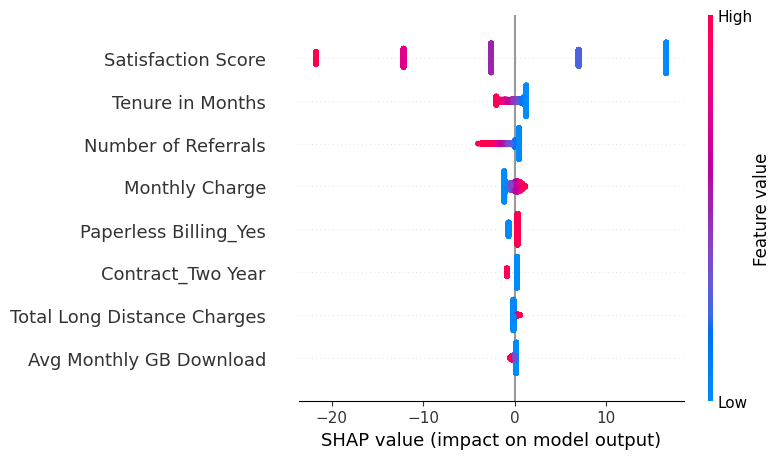

In [60]:
import shap

# Create a SHAP explainer
explainer = shap.LinearExplainer(best_model, X_train_res_scaled, feature_dependence="independent")

# Calculate SHAP values - this might take some time
shap_values = explainer.shap_values(X_train_res_scaled)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_res_scaled, feature_names=features)

### Key Findings
* Satisfaction Score: Higher satisfaction scores seem to decrease the likelihood of the positive class since most points are on the left. Conversely, lower satisfaction scores increase the likelihood of the positive class (points are on the right).
* Tenure in Months: There's a mix here, but longer tenure seems to slightly decrease the likelihood of the positive class, as many points lie on the left side.
* Number of Referrals: It appears to have a mixed impact, with no clear trend.
* Monthly Charge: Higher monthly charges increase the likelihood of the positive class, as many points are on the right side in pink.
* Paperless Billing_Yes: Having paperless billing seems to increase the likelihood of the positive class slightly.
* Contract_Two Year: Having a two-year contract greatly decreases the likelihood of the positive class, as the points are clustered to the left.
* Total Long Distance Charges: This feature has a varied impact, with no clear trend.
* Avg Monthly GB Download: There's a mix, but on average, higher values seem to decrease the likelihood of the positive class, as many points are on the left.

## <b><span style='color:#645f89'>9.2</span> | Feature Importance Plot</b>

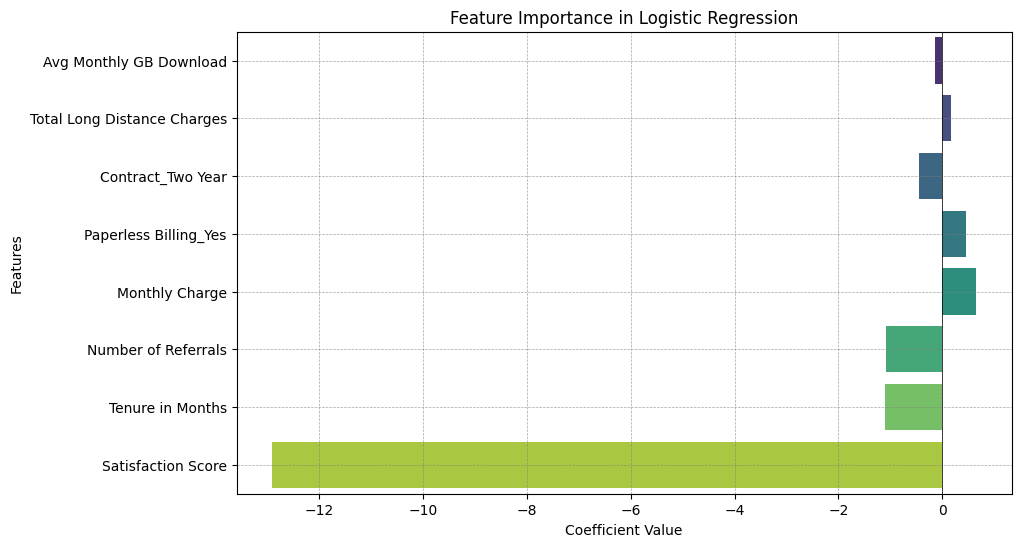

In [75]:
plt.figure(figsize=(10, 6))
# Plot using seaborn
ax = sns.barplot(x=feature_importance[sorted_idx].values, y=sorted_idx, palette="viridis")

# Add grid lines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.axvline(0, color='black', linewidth=0.5)

plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

### Conclusion

1. In predicting customer attrition, logistic regression produced the highest Area Under the Curve, F1 score, and specificity. 
2. Some of the most important predictors of customer attrition include `Satisfaction Score`, `Tenure in Months`, `Number of Referrals`, `Monthly Charges`, `Contract_Two Year`, `Total Long Distance Charges`, and `Paperless Billing_Yes`. 
3. We also found that the most significant relationships from our logistic model are the `Satisfaction Score`,`Tenure in Months`, `Number of Referrals`, `Monthly Charges`, and `Contract_Two Year`. To proactively reduce their churn rate, Telco could target customers who have low satisfaction score, who have a shorter Tenure in Months, have higher monthly charges on average, and whose contract is month-to-month and one-year contract.
